In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.cosmic_shear_marginalized.cosmic_shear as cosmic_shear
import ndes.nde as nde
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples

%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# n(z)
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])
PZ = [0]*nz
for i in range(nz):
    z = np.concatenate([np.linspace(-0.5, 0, 100), pz_fid[i].get_knots()[1:]])
    p = np.concatenate([np.zeros(100), pz_fid[i](pz_fid[i].get_knots()[1:])])
    PZ[i] = interpolate.InterpolatedUnivariateSpline(z, p, k = 3)
pz_fid = PZ

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
npar = 15

# Define the priors
lower = np.zeros(npar)
upper = np.zeros(npar)
lower[0:5] = np.array([0, 0.4, 0, 0.4, 0.7])
lower[5:] = np.ones(nz)*-0.1
upper[0:5] = np.array([1, 1.2, 0.1, 1.0, 1.3])
upper[5:] = np.ones(nz)*0.1
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
sigmas[5:] = np.ones(nz)*0.05
S = np.eye(npar)*sigmas**2
Sinv = np.linalg.inv(S)
prior_args = [prior_mean, S, lower, upper]

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = cosmic_shear.power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.concatenate([abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.1, 0.1, 0.05]), np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])])
dCdt = np.zeros((npar, nz, nz, len(modes)))
# Derivatives wrt cosmological parameters
for i in range(npar-nz):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = cosmic_shear.power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = cosmic_shear.power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])
    
# Derivatives wrt photo-z bias parameters
for i in range(nz):
    
    pzprime = [interpolate.InterpolatedUnivariateSpline(np.linspace(0, pz_fid[0].get_knots()[-1], len(pz_fid[0].get_knots())), np.zeros(len(pz_fid[0].get_knots()))) for X in range(nz)]
    pzprime[i] = pz_fid[i].derivative()
    dCdt[npar-nz+i, :, :, :] = cosmic_shear.d_power_spectrum_db(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz)), pzprime])

# Fisher matrix
F, Finv, fisher_errors = cosmic_shear.fisher_matrix(Cinv, dCdt, npar, nl, Sinv)

# Compute projection matrices
Fpinv = np.linalg.inv(F[5:,5:])
P = np.zeros((5, 10))
for i in range(5):
    P[i,:] = np.dot(Fpinv, F[i,5:])

# Projection arguments
projection_args = [Finv, P, theta_fiducial, fisher_errors, prior_mean, Sinv, Cinv, dCdt, modes, nl]

# SimABC args
simulator_args = [sim_args, projection_args, prior_args]

# Now do the set up for the nuisance projected problem...
npar = 5
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
Q = np.eye(npar)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2
Finv = Finv[0:npar, 0:npar]
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

In [3]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = cosmic_shear.simulation
simulator_args = [sim_args, prior_args, projection_args]

In [4]:
# Define the compression function: takes data, spits out compressed summaries
# Should have the form compressor(data, args) -> compressed summaries
# NB: compression should be set-up like a quasi maximum-likelihood estimator
compressor = cosmic_shear.projected_score
compressor_args = projection_args

In [5]:
# The data vector: import or otherwise simulate for testing
#data = compressor(cosmic_shear.power_spectrum(theta_fiducial, sim_args), compressor_args)
data = compressor(simulator(theta_fiducial, simulator_args), compressor_args)

In [6]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

In [7]:
# Create the DELFI MDN object
n_components = 3

mdn = nde.DelfiMixtureDensityNetwork(data, prior, [lower, upper], Finv, theta_fiducial, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 74s 2ms/step - loss: 17.5433 - val_loss: 12.2202
Epoch 2/100
45000/45000 [==============================] - 73s 2ms/step - loss: 11.3002 - val_loss: 10.5102
Epoch 3/100
45000/45000 [==============================] - 73s 2ms/step - loss: 9.9564 - val_loss: 9.4007
Epoch 4/100
45000/45000 [==============================] - 72s 2ms/step - loss: 9.1313 - val_loss: 8.9657
Epoch 5/100
45000/45000 [==============================] - 73s 2ms/step - loss: 8.5523 - val_loss: 8.4063
Epoch 6/100
45000/45000 [==============================] - 74s 2ms/step - loss: 8.1852 - val_loss: 8.0101
Epoch 7/100
45000/45000 [==============================] - 71s 2ms/step - loss: 7.8704 - val_loss: 7.7173
Epoch 8/100
45000/45000 [==============================] - 73s 2ms/step - loss: 7.6063 - val_loss: 7.5731
Epoch 9/100
45000/45000 [=====

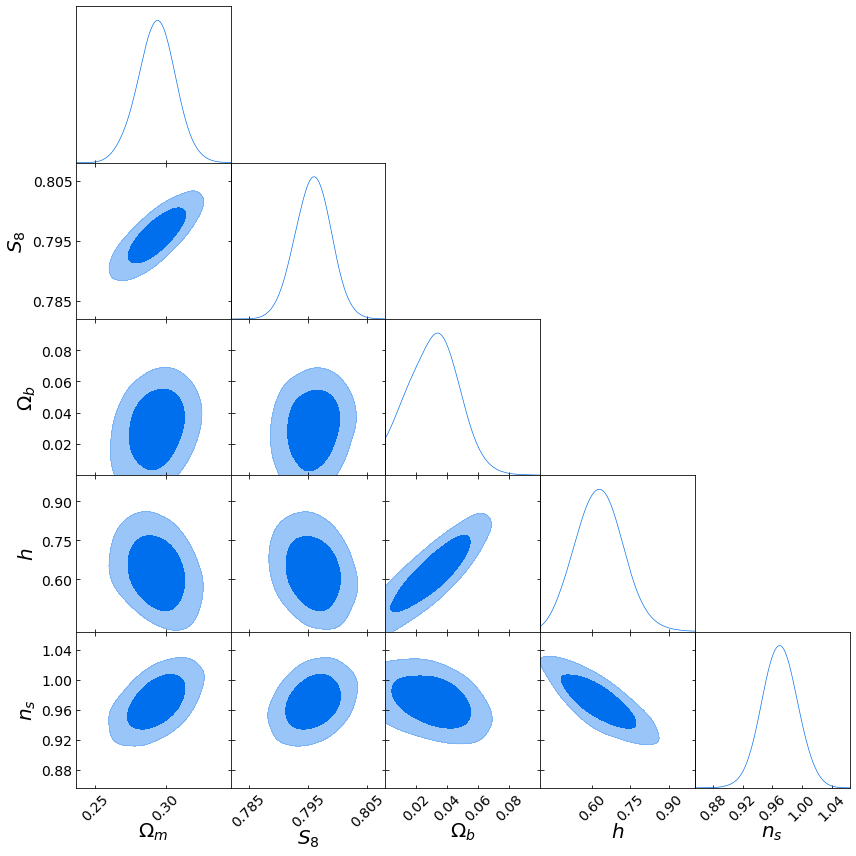

In [8]:
# Do the Fisher pre-training
mdn.fisher_pretraining(50000, prior, epochs=100)

Running initial 500 sims...
Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 1s 3ms/step - loss: 12.7684 - val_loss: 13.5138
Epoch 2/100
450/450 [==============================] - 3s 7ms/step - loss: 10.6153 - val_loss: 8.9345
Epoch 3/100
450/450 [==============================] - 2s 5ms/step - loss: 8.5020 - val_loss: 8.2286
Epoch 4/100
450/450 [==============================] - 3s 8ms/step - loss: 7.4691 - val_loss: 8.4643
Epoch 5/100
450/450 [==============================] - 2s 3ms/step - loss: 7.2433 - val_loss: 8.0677
Epoch 6/100
450/450 [==============================] - 1s 2ms/step - loss: 6.6361 - val_loss: 8.5470
Epoch 7/100
450/450 [==============================] - 1s 2ms/step - loss: 6.4741 - val_loss: 7.7988
Epoch 8/100
450/450 [==============================] - 1s 2ms/step - loss: 6.2356 - val_loss: 7.5744
Epoch 9/100
450/450 [==============================] - 1s 2ms/step - loss: 5.9644 - val_loss: 8.0913
Epoch 10/

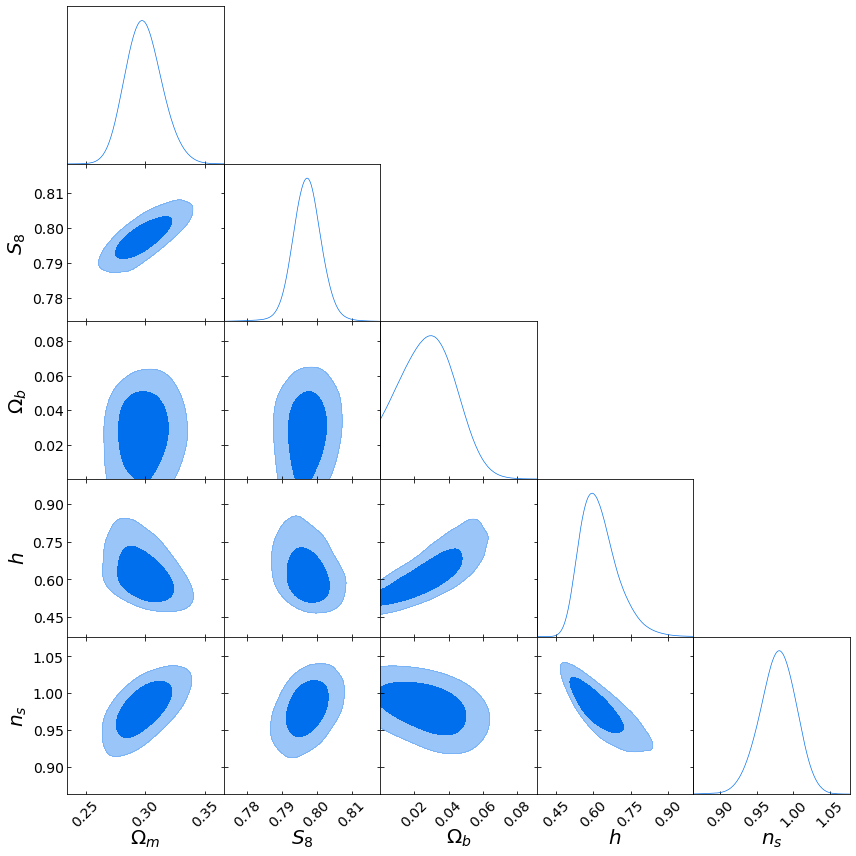

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 2s 2ms/step - loss: 4.1229 - val_loss: 3.8582
Epoch 2/100
900/900 [==============================] - 2s 2ms/step - loss: 4.1916 - val_loss: 3.7610
Epoch 3/100
900/900 [==============================] - 2s 2ms/step - loss: 4.0938 - val_loss: 3.8522
Epoch 4/100
900/900 [==============================] - 2s 2ms/step - loss: 4.1085 - val_loss: 3.7687
Epoch 5/100
900/900 [==============================] - 2s 2ms/step - loss: 4.1297 - val_loss: 3.7594
Epoch 6/100
900/900 [==============================] - 2s 2ms/step - loss: 4.1233 - val_loss: 3.6969
Epoch 7/100
900/900 [==============================] - 2s 2ms/step - loss: 4.0986 - val_loss: 3.7291
Epoch 8/100
900/900 [==============================] - 2s 2ms/step - loss: 4.0795 - val_loss: 3.7740
Epoch 9/100
900/900 [==============================] - 2s 2ms/step - 

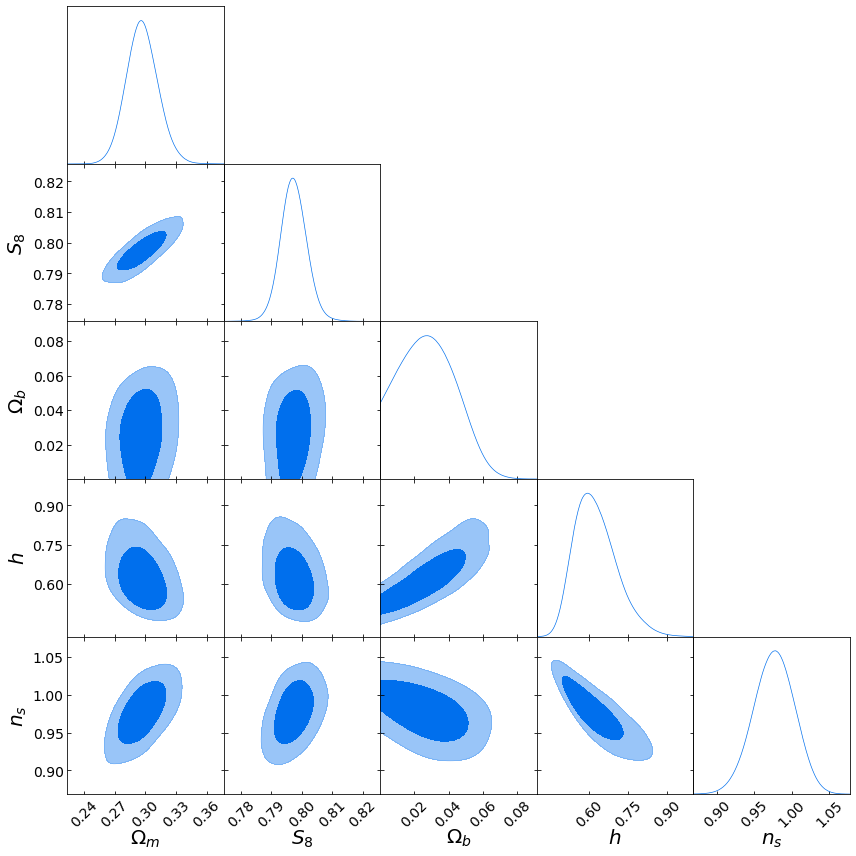

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.9428 - val_loss: 4.1638
Epoch 2/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.9973 - val_loss: 4.2028
Epoch 3/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.9935 - val_loss: 4.1709
Epoch 4/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.9876 - val_loss: 4.1239
Epoch 5/100
1350/1350 [==============================] - 2s 2ms/step - loss: 4.0431 - val_loss: 4.2025
Epoch 6/100
1350/1350 [==============================] - 2s 2ms/step - loss: 4.0049 - val_loss: 4.2374
Epoch 7/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.9733 - val_loss: 4.1374
Epoch 8/100
1350/1350 [==============================] - 2s 2ms/step - loss: 3.9361 - val_loss: 4.1111
Epoch 9/100
1350/1350 [=============================

Epoch 35/100
1350/1350 [==============================] - 3s 2ms/step - loss: 3.8219 - val_loss: 4.0656
Epoch 36/100
1350/1350 [==============================] - 3s 2ms/step - loss: 3.8219 - val_loss: 4.0661
Epoch 37/100
1350/1350 [==============================] - 3s 2ms/step - loss: 3.8213 - val_loss: 4.0649
Epoch 38/100
1350/1350 [==============================] - 3s 2ms/step - loss: 3.8210 - val_loss: 4.0607
Epoch 39/100
1350/1350 [==============================] - 3s 2ms/step - loss: 3.8204 - val_loss: 4.0572
Epoch 40/100
1350/1350 [==============================] - 3s 2ms/step - loss: 3.8204 - val_loss: 4.0564
Epoch 41/100
1350/1350 [==============================] - 3s 2ms/step - loss: 3.8203 - val_loss: 4.0581
Epoch 42/100
1350/1350 [==============================] - 3s 2ms/step - loss: 3.8199 - val_loss: 4.0606
Epoch 43/100
1350/1350 [==============================] - 3s 2ms/step - loss: 3.8199 - val_loss: 4.0614
Epoch 44/100
1350/1350 [==============================] - 3s 2ms

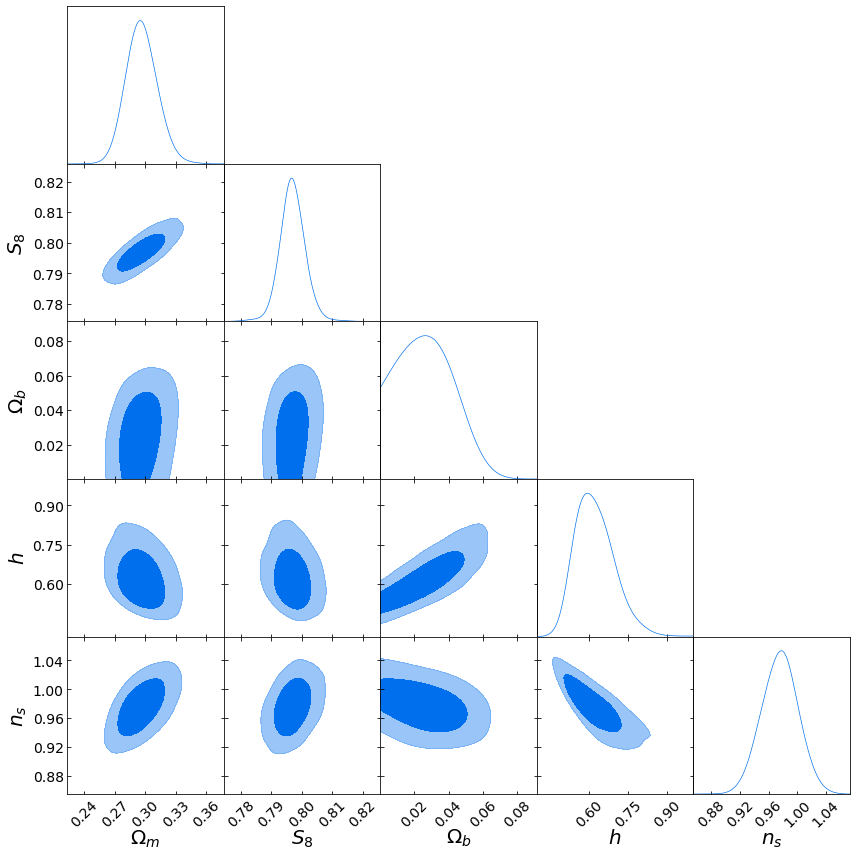

Population 3/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.8967 - val_loss: 3.9914
Epoch 2/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.9734 - val_loss: 4.0206
Epoch 3/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.9855 - val_loss: 4.0240
Epoch 4/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.9130 - val_loss: 3.9536
Epoch 5/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.8993 - val_loss: 4.0049
Epoch 6/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.8918 - val_loss: 3.9396
Epoch 7/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.9037 - val_loss: 3.9723
Epoch 8/100
1800/1800 [==============================] - 3s 2ms/step - loss: 3.9554 - val_loss: 3.9807
Epoch 9/100
1800/1800 [=============================

Epoch 48/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.7947 - val_loss: 3.9133
Epoch 49/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.7947 - val_loss: 3.9146
Epoch 50/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.7946 - val_loss: 3.9138
Epoch 51/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.7943 - val_loss: 3.9132
Epoch 52/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.7944 - val_loss: 3.9138
Epoch 53/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.7942 - val_loss: 3.9151
Epoch 54/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.7941 - val_loss: 3.9152
Epoch 55/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.7941 - val_loss: 3.9136
Epoch 56/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.7940 - val_loss: 3.9123
Epoch 57/100
1800/1800 [==============================] - 4s 2ms

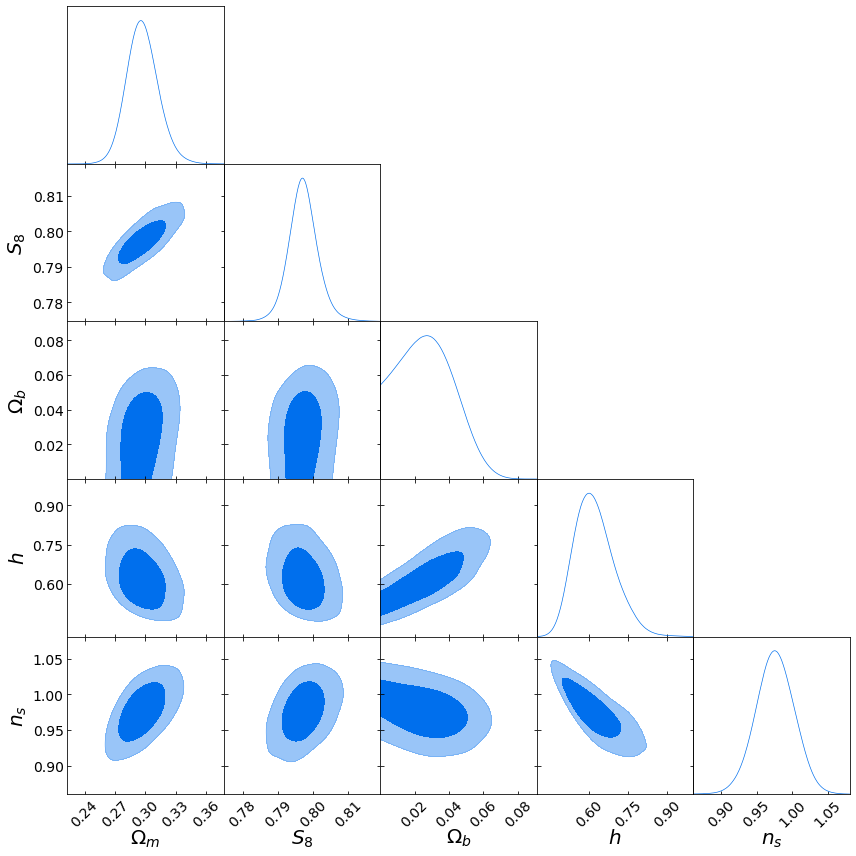

Population 4/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2250 samples, validate on 250 samples
Epoch 1/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.8610 - val_loss: 3.9556
Epoch 2/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.9466 - val_loss: 4.0821
Epoch 3/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.8840 - val_loss: 3.9642
Epoch 4/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.9521 - val_loss: 3.9632
Epoch 5/100
2250/2250 [==============================] - 6s 2ms/step - loss: 3.9182 - val_loss: 3.9632
Epoch 6/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.8802 - val_loss: 3.9697
Epoch 7/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.8809 - val_loss: 3.9481
Epoch 8/100
2250/2250 [==============================] - 5s 2ms/step - loss: 3.8977 - val_loss: 3.9418
Epoch 9/100
2250/2250 [=============================

Epoch 37/100
2250/2250 [==============================] - 7s 3ms/step - loss: 3.7840 - val_loss: 3.9249
Epoch 38/100
2250/2250 [==============================] - 7s 3ms/step - loss: 3.7842 - val_loss: 3.9201
Epoch 39/100
2250/2250 [==============================] - 7s 3ms/step - loss: 3.7823 - val_loss: 3.9193
Epoch 40/100
2250/2250 [==============================] - 7s 3ms/step - loss: 3.7837 - val_loss: 3.9189
Epoch 41/100
2250/2250 [==============================] - 7s 3ms/step - loss: 3.7831 - val_loss: 3.9198
Epoch 42/100
2250/2250 [==============================] - 7s 3ms/step - loss: 3.7823 - val_loss: 3.9223
Epoch 43/100
2250/2250 [==============================] - 7s 3ms/step - loss: 3.7832 - val_loss: 3.9206
Epoch 44/100
2250/2250 [==============================] - 7s 3ms/step - loss: 3.7821 - val_loss: 3.9188
Epoch 45/100
2250/2250 [==============================] - 7s 3ms/step - loss: 3.7820 - val_loss: 3.9187
Epoch 46/100
2250/2250 [==============================] - 7s 3ms

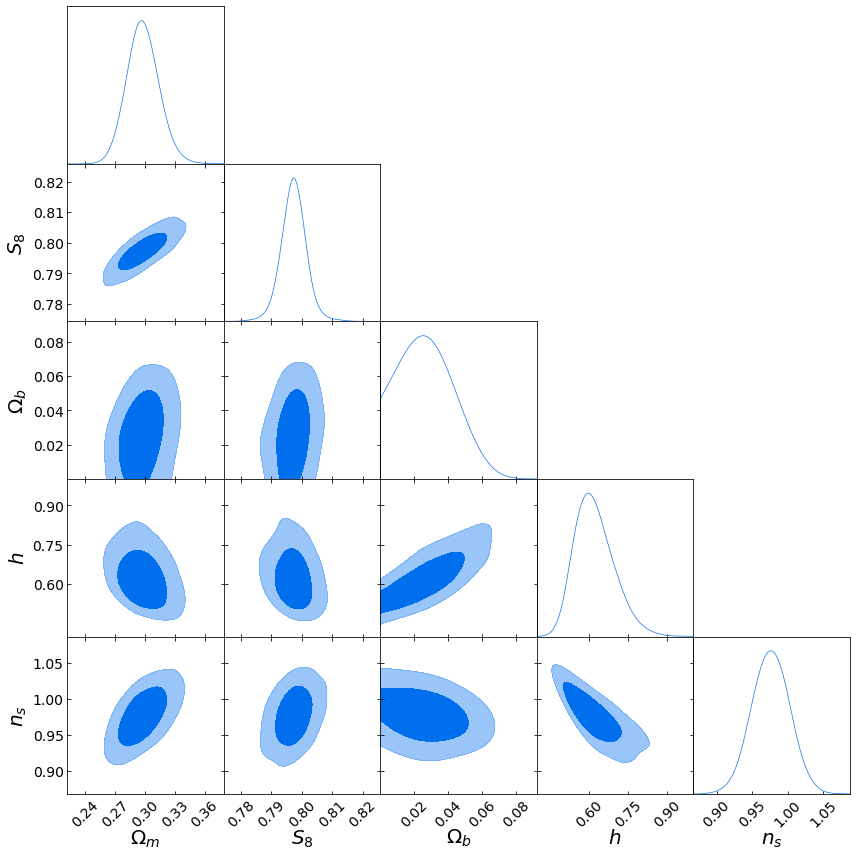

Population 5/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.8433 - val_loss: 3.8478
Epoch 2/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.8739 - val_loss: 3.8765
Epoch 3/100
2700/2700 [==============================] - 5s 2ms/step - loss: 3.8563 - val_loss: 3.7950
Epoch 4/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.8774 - val_loss: 3.7835
Epoch 5/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.8505 - val_loss: 3.8198
Epoch 6/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.8938 - val_loss: 3.8003
Epoch 7/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.8808 - val_loss: 3.9247
Epoch 8/100
2700/2700 [==============================] - 6s 2ms/step - loss: 3.8762 - val_loss: 3.8856
Epoch 9/100
2700/2700 [=============================

2700/2700 [==============================] - 8s 3ms/step - loss: 3.7764 - val_loss: 3.7608
Epoch 34/100
2700/2700 [==============================] - 18s 7ms/step - loss: 3.7765 - val_loss: 3.7637
Epoch 35/100
2700/2700 [==============================] - 14s 5ms/step - loss: 3.7789 - val_loss: 3.7579
Epoch 36/100
2700/2700 [==============================] - 9s 3ms/step - loss: 3.7758 - val_loss: 3.7555
Epoch 37/100
2700/2700 [==============================] - 9s 3ms/step - loss: 3.7761 - val_loss: 3.7552
Epoch 38/100
2700/2700 [==============================] - 9s 3ms/step - loss: 3.7756 - val_loss: 3.7562
Epoch 39/100
2700/2700 [==============================] - 9s 3ms/step - loss: 3.7741 - val_loss: 3.7600
Epoch 40/100
2700/2700 [==============================] - 9s 3ms/step - loss: 3.7759 - val_loss: 3.7576
Epoch 41/100
2700/2700 [==============================] - 9s 3ms/step - loss: 3.7750 - val_loss: 3.7540
Epoch 42/100
2700/2700 [==============================] - 9s 3ms/step - los

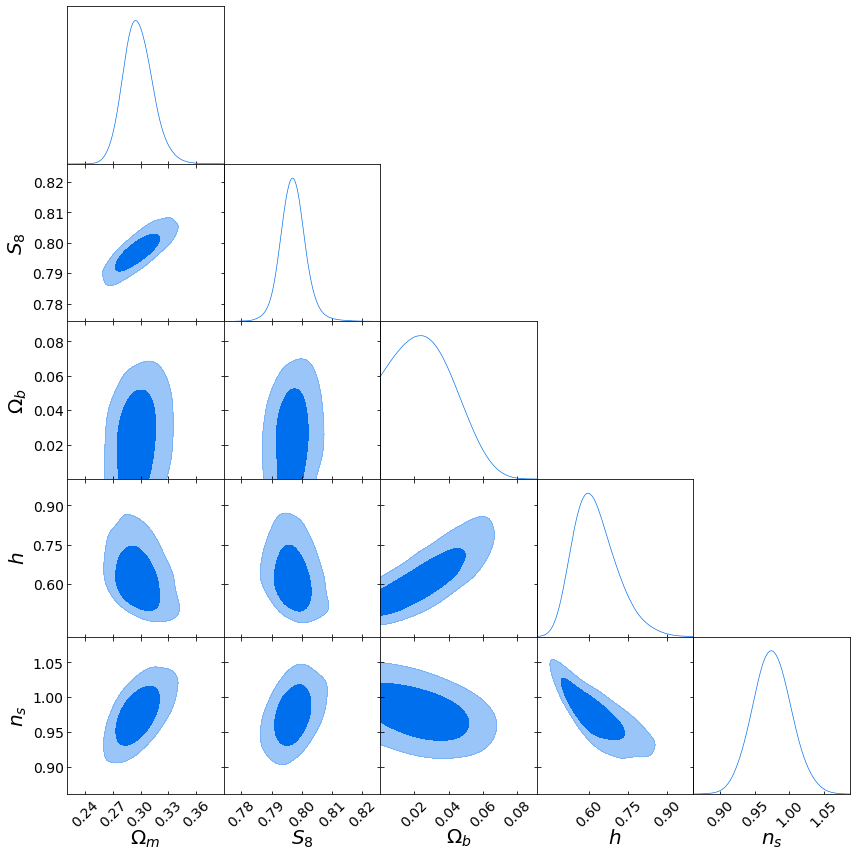

Population 6/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3150 samples, validate on 350 samples
Epoch 1/100
3150/3150 [==============================] - 6s 2ms/step - loss: 3.8811 - val_loss: 3.9253
Epoch 2/100
3150/3150 [==============================] - 6s 2ms/step - loss: 3.9036 - val_loss: 3.8676
Epoch 3/100
3150/3150 [==============================] - 6s 2ms/step - loss: 3.8673 - val_loss: 4.0112
Epoch 4/100
3150/3150 [==============================] - 6s 2ms/step - loss: 3.9356 - val_loss: 3.9193
Epoch 5/100
3150/3150 [==============================] - 6s 2ms/step - loss: 3.9029 - val_loss: 3.9004
Epoch 6/100
3150/3150 [==============================] - 6s 2ms/step - loss: 3.9482 - val_loss: 3.8402
Epoch 7/100
3150/3150 [==============================] - 6s 2ms/step - loss: 3.8540 - val_loss: 3.8614
Epoch 8/100
3150/3150 [==============================] - 6s 2ms/step - loss: 3.9222 - val_loss: 3.8748
Epoch 9/100
3150/3150 [=============================

Epoch 47/100
3150/3150 [==============================] - 9s 3ms/step - loss: 3.7584 - val_loss: 3.8084
Epoch 48/100
3150/3150 [==============================] - 9s 3ms/step - loss: 3.7572 - val_loss: 3.8122
Epoch 49/100
3150/3150 [==============================] - 9s 3ms/step - loss: 3.7579 - val_loss: 3.8119
Epoch 50/100
3150/3150 [==============================] - 9s 3ms/step - loss: 3.7574 - val_loss: 3.8091
Epoch 51/100
3150/3150 [==============================] - 9s 3ms/step - loss: 3.7570 - val_loss: 3.8083
Epoch 52/100
3150/3150 [==============================] - 10s 3ms/step - loss: 3.7575 - val_loss: 3.8097
Epoch 53/100
3150/3150 [==============================] - 9s 3ms/step - loss: 3.7568 - val_loss: 3.8128
Epoch 54/100
3150/3150 [==============================] - 9s 3ms/step - loss: 3.7569 - val_loss: 3.8135
Epoch 55/100
3150/3150 [==============================] - 9s 3ms/step - loss: 3.7571 - val_loss: 3.8108
Epoch 56/100
3150/3150 [==============================] - 9s 3m

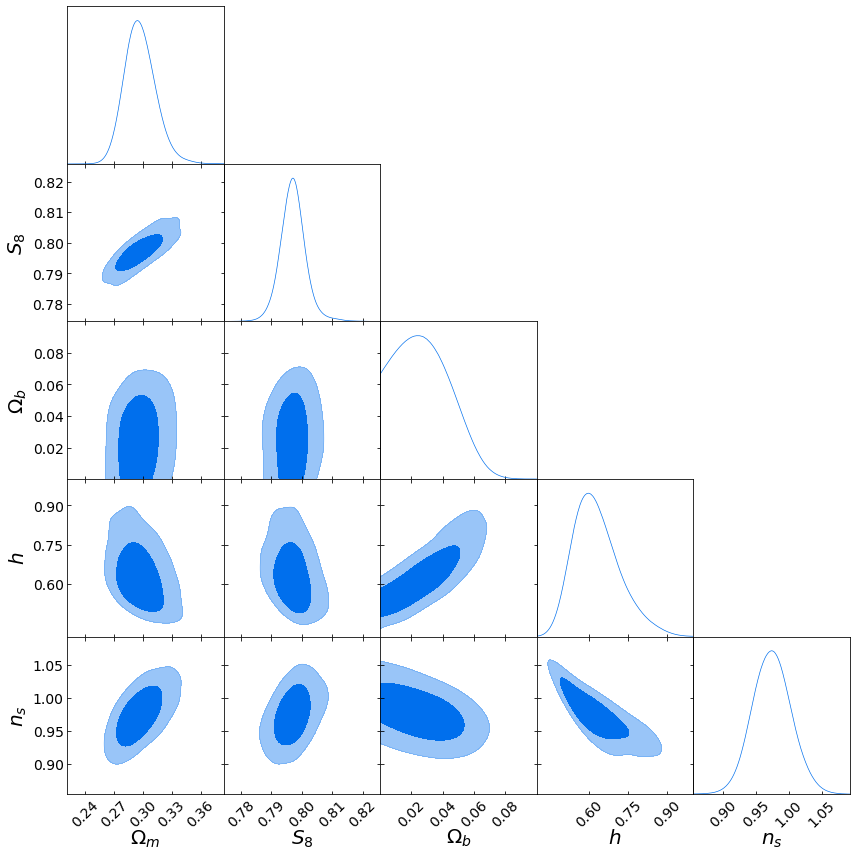

Population 7/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 7s 2ms/step - loss: 3.8433 - val_loss: 3.7901
Epoch 2/100
3600/3600 [==============================] - 7s 2ms/step - loss: 3.8563 - val_loss: 3.8132
Epoch 3/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.9398 - val_loss: 3.7853
Epoch 4/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.8719 - val_loss: 3.8088
Epoch 5/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.8551 - val_loss: 3.8179
Epoch 6/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.9167 - val_loss: 3.7685
Epoch 7/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.8514 - val_loss: 3.7679
Epoch 8/100
3600/3600 [==============================] - 6s 2ms/step - loss: 3.9284 - val_loss: 3.8010
Epoch 9/100
3600/3600 [=============================

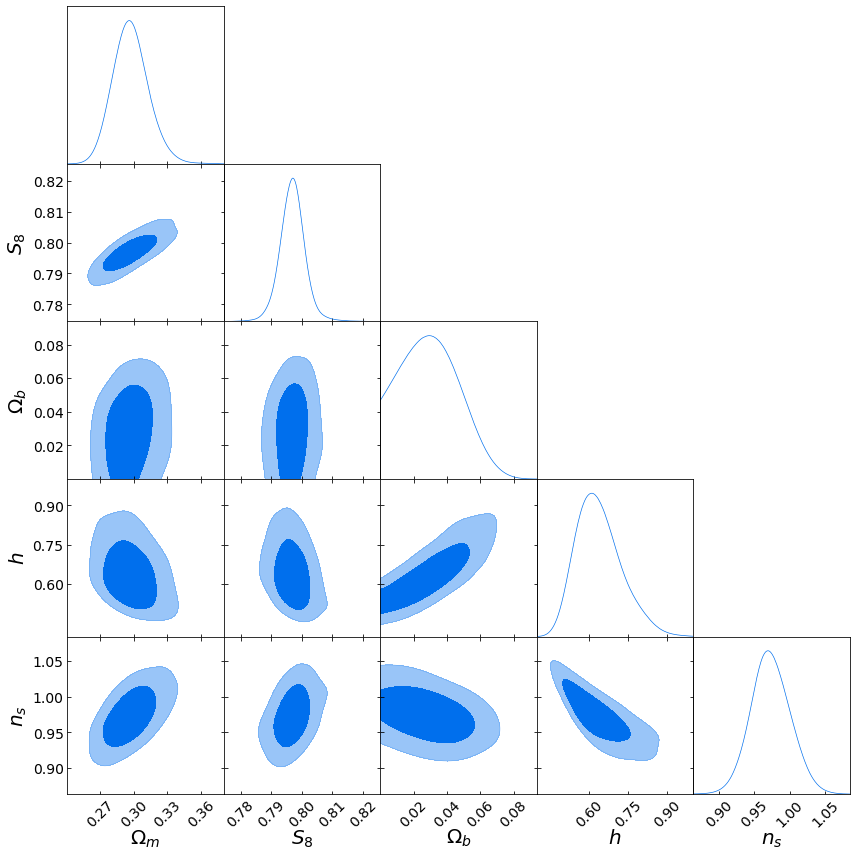

Population 8/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4050 samples, validate on 450 samples
Epoch 1/100
4050/4050 [==============================] - 7s 2ms/step - loss: 3.8423 - val_loss: 3.9678
Epoch 2/100
4050/4050 [==============================] - 7s 2ms/step - loss: 3.8438 - val_loss: 3.8850
Epoch 3/100
4050/4050 [==============================] - 138s 34ms/step - loss: 3.8501 - val_loss: 3.8779
Epoch 4/100
4050/4050 [==============================] - 22s 5ms/step - loss: 3.8760 - val_loss: 3.9344
Epoch 5/100
4050/4050 [==============================] - 16s 4ms/step - loss: 3.8639 - val_loss: 3.8547
Epoch 6/100
4050/4050 [==============================] - 3607s 891ms/step - loss: 3.8383 - val_loss: 3.8783
Epoch 7/100
4050/4050 [==============================] - 14s 3ms/step - loss: 3.8426 - val_loss: 3.9617
Epoch 8/100
4050/4050 [==============================] - 17s 4ms/step - loss: 3.8440 - val_loss: 3.9404
Epoch 9/100
4050/4050 [=================

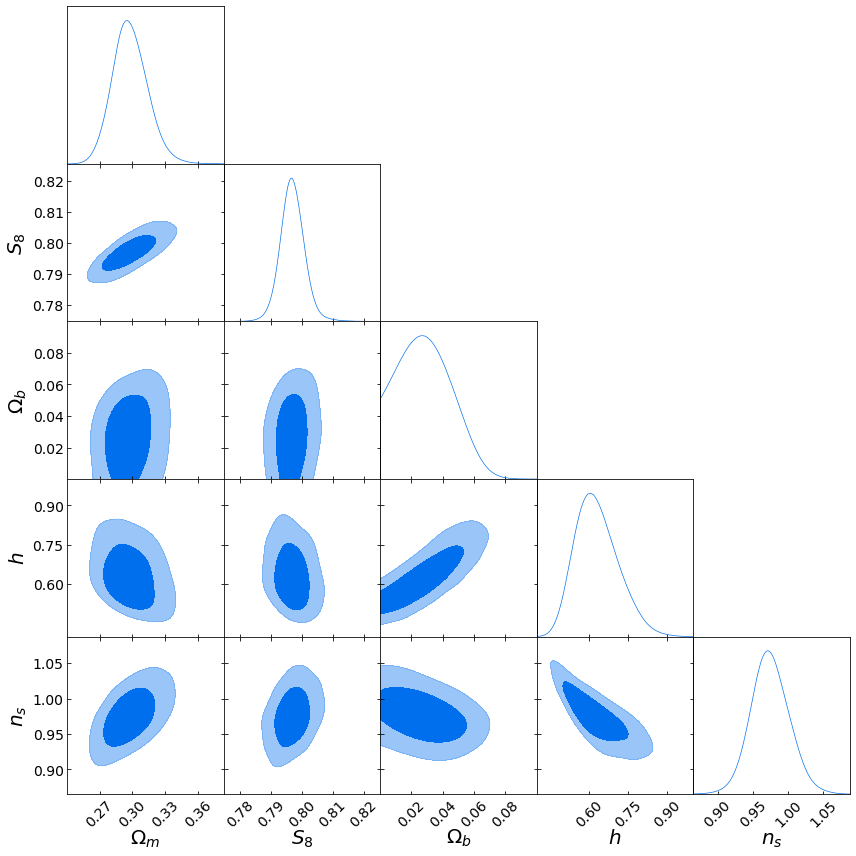

Population 9/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8270 - val_loss: 3.8641
Epoch 2/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8366 - val_loss: 3.9495
Epoch 3/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8630 - val_loss: 3.8817
Epoch 4/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8446 - val_loss: 3.8636
Epoch 5/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8773 - val_loss: 4.0007
Epoch 6/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8690 - val_loss: 3.9014
Epoch 7/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8655 - val_loss: 3.8525
Epoch 8/100
4500/4500 [==============================] - 7s 2ms/step - loss: 3.8694 - val_loss: 3.8789
Epoch 9/100
4500/4500 [=============================

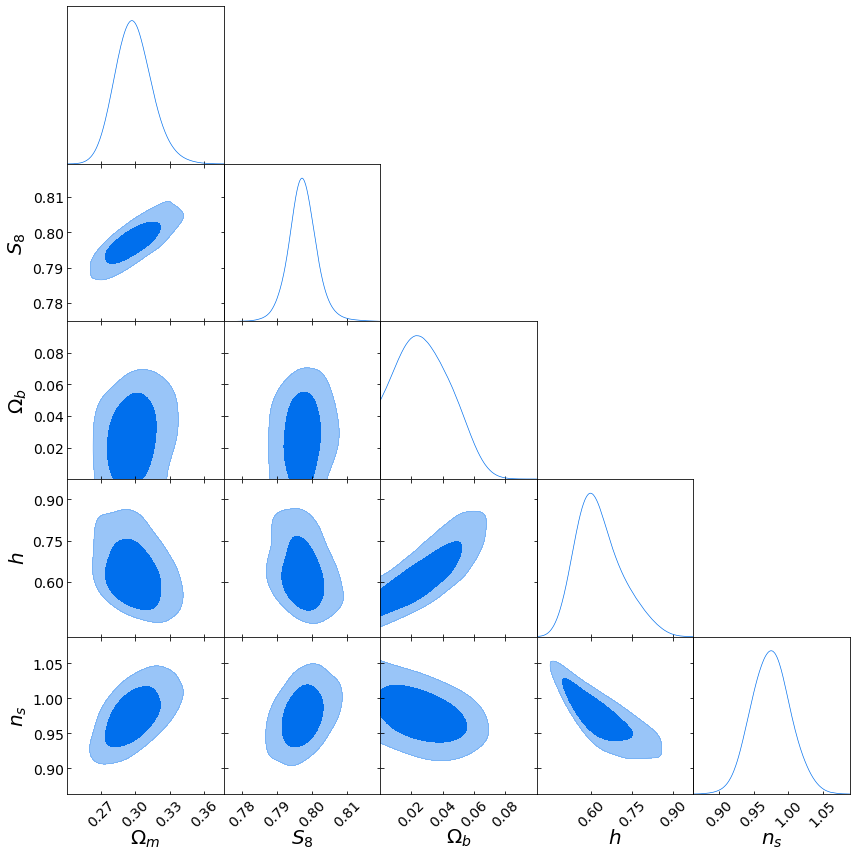

Population 10/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4950 samples, validate on 550 samples
Epoch 1/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.8257 - val_loss: 4.0043
Epoch 2/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.8932 - val_loss: 3.8611
Epoch 3/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.8492 - val_loss: 3.8904
Epoch 4/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.8504 - val_loss: 3.8472
Epoch 5/100
4950/4950 [==============================] - 6s 1ms/step - loss: 3.9117 - val_loss: 3.9018
Epoch 6/100
4950/4950 [==============================] - 6s 1ms/step - loss: 3.8579 - val_loss: 3.8584
Epoch 7/100
4950/4950 [==============================] - 6s 1ms/step - loss: 3.8348 - val_loss: 3.8819
Epoch 8/100
4950/4950 [==============================] - 7s 1ms/step - loss: 3.8452 - val_loss: 3.9113
Epoch 9/100
4950/4950 [============================

Epoch 44/100
4950/4950 [==============================] - 13s 3ms/step - loss: 3.7454 - val_loss: 3.7981
Epoch 45/100
4950/4950 [==============================] - 14s 3ms/step - loss: 3.7470 - val_loss: 3.7956
Epoch 46/100
4950/4950 [==============================] - 14s 3ms/step - loss: 3.7460 - val_loss: 3.7911
Epoch 47/100
4950/4950 [==============================] - 13s 3ms/step - loss: 3.7452 - val_loss: 3.7894
Epoch 48/100
4950/4950 [==============================] - 14s 3ms/step - loss: 3.7460 - val_loss: 3.7885
Epoch 49/100
4950/4950 [==============================] - 14s 3ms/step - loss: 3.7452 - val_loss: 3.7897
Epoch 50/100
4950/4950 [==============================] - 13s 3ms/step - loss: 3.7452 - val_loss: 3.7909
Epoch 51/100
4950/4950 [==============================] - 14s 3ms/step - loss: 3.7459 - val_loss: 3.7889
Epoch 52/100
4950/4950 [==============================] - 20s 4ms/step - loss: 3.7450 - val_loss: 3.7872
Epoch 53/100
4950/4950 [==============================]

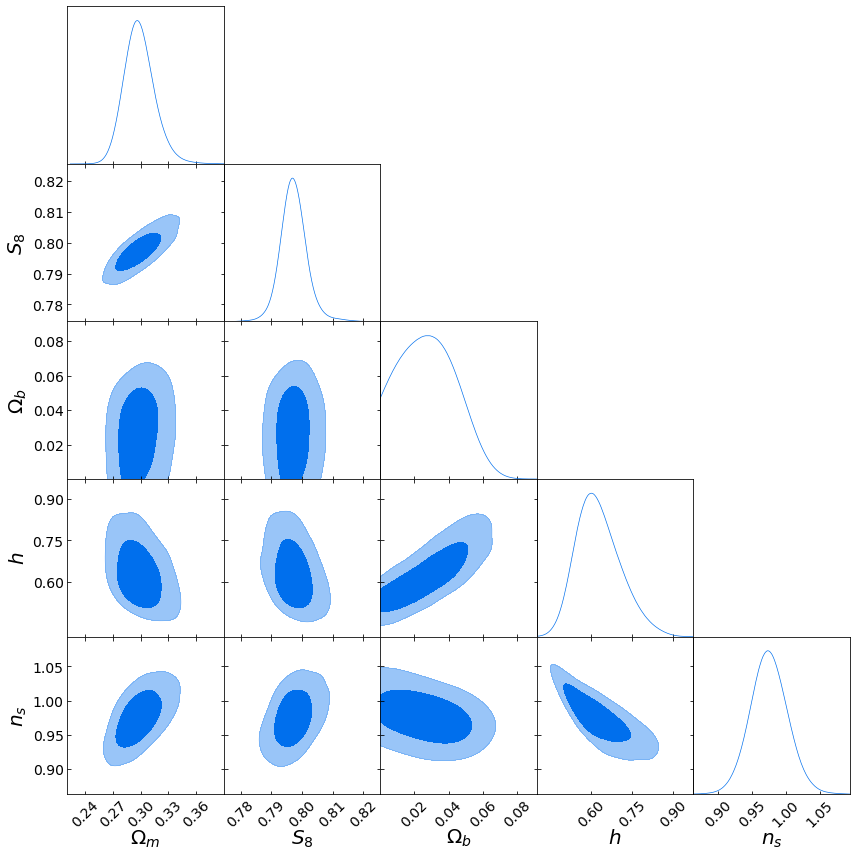

Population 11/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.8329 - val_loss: 3.8112
Epoch 2/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.8541 - val_loss: 3.7375
Epoch 3/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.8486 - val_loss: 3.7661
Epoch 4/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.8601 - val_loss: 3.8373
Epoch 5/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.8670 - val_loss: 3.7918
Epoch 6/100
5400/5400 [==============================] - 9s 2ms/step - loss: 3.8449 - val_loss: 3.7730
Epoch 7/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.8478 - val_loss: 3.8001
Epoch 8/100
5400/5400 [==============================] - 8s 1ms/step - loss: 3.8402 - val_loss: 3.7585
Epoch 9/100
5400/5400 [============================

Epoch 56/100
5400/5400 [==============================] - 18s 3ms/step - loss: 3.7441 - val_loss: 3.7102
Epoch 57/100
5400/5400 [==============================] - 18s 3ms/step - loss: 3.7443 - val_loss: 3.7103
Epoch 58/100
5400/5400 [==============================] - 19s 4ms/step - loss: 3.7442 - val_loss: 3.7105
Epoch 59/100
5400/5400 [==============================] - 18s 3ms/step - loss: 3.7441 - val_loss: 3.7106
Epoch 60/100
5400/5400 [==============================] - 18s 3ms/step - loss: 3.7442 - val_loss: 3.7104
Epoch 61/100
5400/5400 [==============================] - 19s 3ms/step - loss: 3.7441 - val_loss: 3.7103
Epoch 62/100
5400/5400 [==============================] - 19s 4ms/step - loss: 3.7440 - val_loss: 3.7103
Epoch 63/100
5400/5400 [==============================] - 18s 3ms/step - loss: 3.7441 - val_loss: 3.7105
Epoch 64/100
5400/5400 [==============================] - 18s 3ms/step - loss: 3.7440 - val_loss: 3.7109
Epoch 65/100
5400/5400 [==============================]

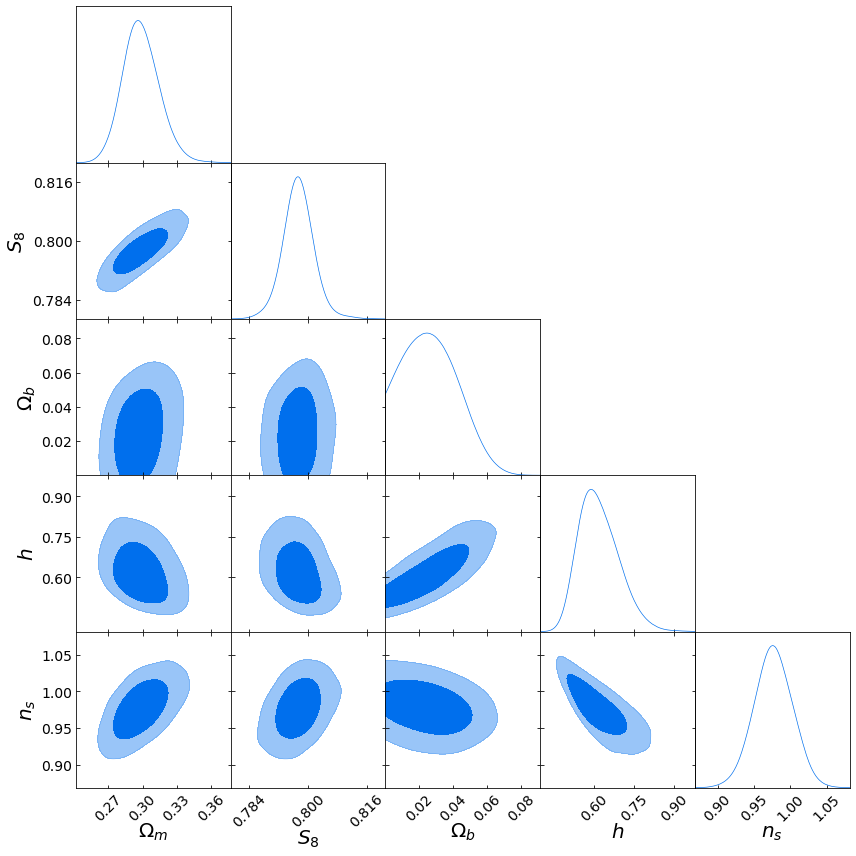

Population 12/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 5850 samples, validate on 650 samples
Epoch 1/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.8276 - val_loss: 3.8012
Epoch 2/100
5850/5850 [==============================] - 9s 2ms/step - loss: 3.8386 - val_loss: 3.7674
Epoch 3/100
5850/5850 [==============================] - 9s 2ms/step - loss: 3.8331 - val_loss: 3.7903
Epoch 4/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.8581 - val_loss: 3.7654
Epoch 5/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.8247 - val_loss: 3.9326
Epoch 6/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.8792 - val_loss: 3.7402
Epoch 7/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.8386 - val_loss: 3.7737
Epoch 8/100
5850/5850 [==============================] - 10s 2ms/step - loss: 3.8724 - val_loss: 3.8365
Epoch 9/100
5850/5850 [======================

Epoch 3/100
5850/5850 [==============================] - 20s 3ms/step - loss: 3.8026 - val_loss: 3.7728
Epoch 4/100
5850/5850 [==============================] - 22s 4ms/step - loss: 3.8261 - val_loss: 3.7409
Epoch 5/100
5850/5850 [==============================] - 22s 4ms/step - loss: 3.7809 - val_loss: 3.7287
Epoch 6/100
5850/5850 [==============================] - 27s 5ms/step - loss: 3.7617 - val_loss: 3.7622
Epoch 7/100
5850/5850 [==============================] - 22s 4ms/step - loss: 3.8005 - val_loss: 3.7447
Epoch 8/100
5850/5850 [==============================] - 21s 4ms/step - loss: 3.7867 - val_loss: 3.7272
Epoch 9/100
5850/5850 [==============================] - 20s 3ms/step - loss: 3.7682 - val_loss: 3.7472
Epoch 10/100
5850/5850 [==============================] - 21s 4ms/step - loss: 3.7871 - val_loss: 3.7336
Epoch 11/100
5850/5850 [==============================] - 20s 3ms/step - loss: 3.7700 - val_loss: 3.7161
Epoch 12/100
5850/5850 [==============================] - 20s 

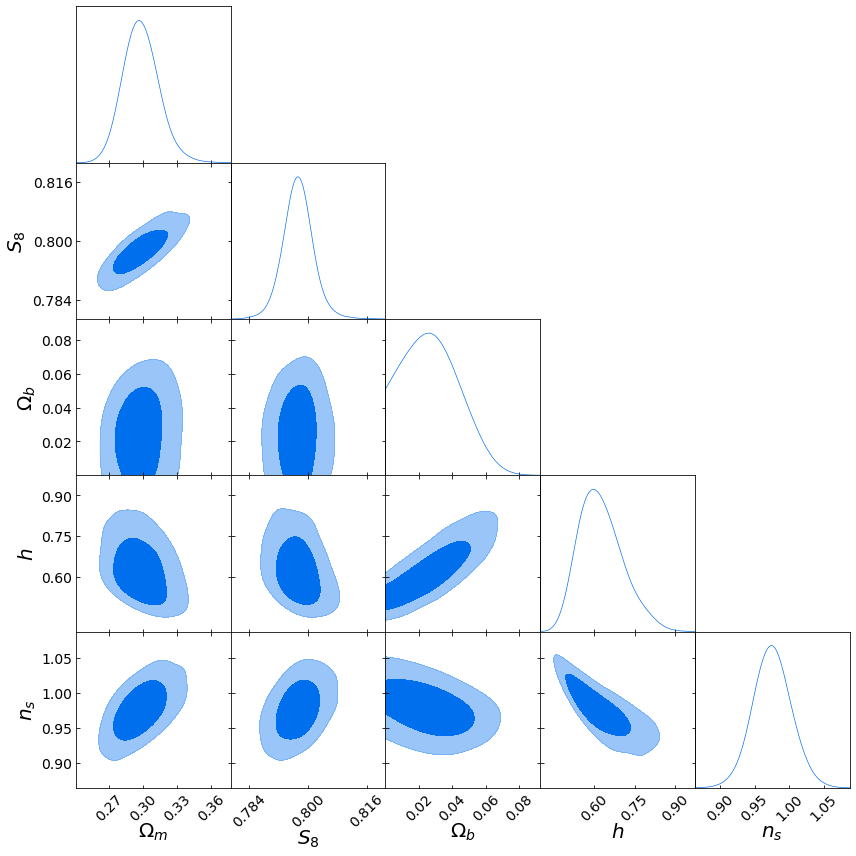

Population 13/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 6300 samples, validate on 700 samples
Epoch 1/100
6300/6300 [==============================] - 23s 4ms/step - loss: 3.7983 - val_loss: 3.8716
Epoch 2/100
6300/6300 [==============================] - 16s 2ms/step - loss: 3.8399 - val_loss: 3.9365
Epoch 3/100
6300/6300 [==============================] - 21s 3ms/step - loss: 3.8603 - val_loss: 4.0312
Epoch 4/100
6300/6300 [==============================] - 16s 3ms/step - loss: 3.8829 - val_loss: 3.8782
Epoch 5/100
6300/6300 [==============================] - 11s 2ms/step - loss: 3.8000 - val_loss: 3.8851
Epoch 6/100
6300/6300 [==============================] - 11s 2ms/step - loss: 3.8066 - val_loss: 3.9186
Epoch 7/100
6300/6300 [==============================] - 11s 2ms/step - loss: 3.8122 - val_loss: 3.8700
Epoch 8/100
6300/6300 [==============================] - 12s 2ms/step - loss: 3.8152 - val_loss: 3.9213
Epoch 9/100
6300/6300 [====================

Epoch 45/100
6300/6300 [==============================] - 24s 4ms/step - loss: 3.7271 - val_loss: 3.8180
Epoch 46/100
6300/6300 [==============================] - 25s 4ms/step - loss: 3.7269 - val_loss: 3.8172
Epoch 47/100
6300/6300 [==============================] - 24s 4ms/step - loss: 3.7264 - val_loss: 3.8174
Epoch 48/100
6300/6300 [==============================] - 24s 4ms/step - loss: 3.7268 - val_loss: 3.8174
Epoch 49/100
6300/6300 [==============================] - 24s 4ms/step - loss: 3.7267 - val_loss: 3.8173
Epoch 50/100
6300/6300 [==============================] - 24s 4ms/step - loss: 3.7264 - val_loss: 3.8177
Epoch 51/100
6300/6300 [==============================] - 24s 4ms/step - loss: 3.7266 - val_loss: 3.8179
Epoch 52/100
6300/6300 [==============================] - 24s 4ms/step - loss: 3.7265 - val_loss: 3.8178
Epoch 53/100
6300/6300 [==============================] - 24s 4ms/step - loss: 3.7262 - val_loss: 3.8182
Epoch 54/100
6300/6300 [==============================]

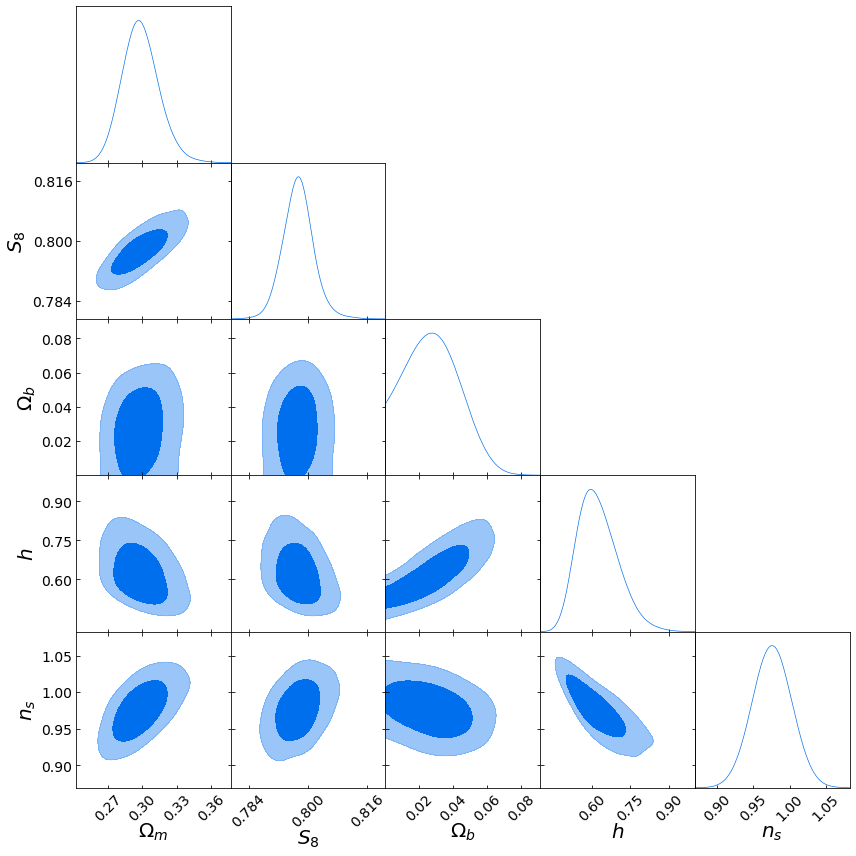

Population 14/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 6750 samples, validate on 750 samples
Epoch 1/100
6750/6750 [==============================] - 12s 2ms/step - loss: 3.8062 - val_loss: 3.8109
Epoch 2/100
6750/6750 [==============================] - 11s 2ms/step - loss: 3.8122 - val_loss: 3.8176
Epoch 3/100
6750/6750 [==============================] - 11s 2ms/step - loss: 3.8136 - val_loss: 3.8142
Epoch 4/100
6750/6750 [==============================] - 11s 2ms/step - loss: 3.8238 - val_loss: 3.8100
Epoch 5/100
6750/6750 [==============================] - 11s 2ms/step - loss: 3.8286 - val_loss: 3.9867
Epoch 6/100
6750/6750 [==============================] - 12s 2ms/step - loss: 3.8309 - val_loss: 3.8655
Epoch 7/100
6750/6750 [==============================] - 11s 2ms/step - loss: 3.8324 - val_loss: 3.9189
Epoch 8/100
6750/6750 [==============================] - 11s 2ms/step - loss: 3.8267 - val_loss: 3.8069
Epoch 9/100
6750/6750 [====================

Epoch 50/100
6750/6750 [==============================] - 27s 4ms/step - loss: 3.7279 - val_loss: 3.7780
Epoch 51/100
6750/6750 [==============================] - 28s 4ms/step - loss: 3.7277 - val_loss: 3.7778
Epoch 52/100
6750/6750 [==============================] - 28s 4ms/step - loss: 3.7278 - val_loss: 3.7774
Epoch 53/100
6750/6750 [==============================] - 27s 4ms/step - loss: 3.7276 - val_loss: 3.7770
Epoch 54/100
6750/6750 [==============================] - 27s 4ms/step - loss: 3.7275 - val_loss: 3.7769
Epoch 55/100
6750/6750 [==============================] - 27s 4ms/step - loss: 3.7276 - val_loss: 3.7767
Epoch 56/100
6750/6750 [==============================] - 32s 5ms/step - loss: 3.7276 - val_loss: 3.7762
Epoch 57/100
6750/6750 [==============================] - 27s 4ms/step - loss: 3.7274 - val_loss: 3.7760
Epoch 58/100
6750/6750 [==============================] - 27s 4ms/step - loss: 3.7274 - val_loss: 3.7760
Epoch 59/100
6750/6750 [==============================]

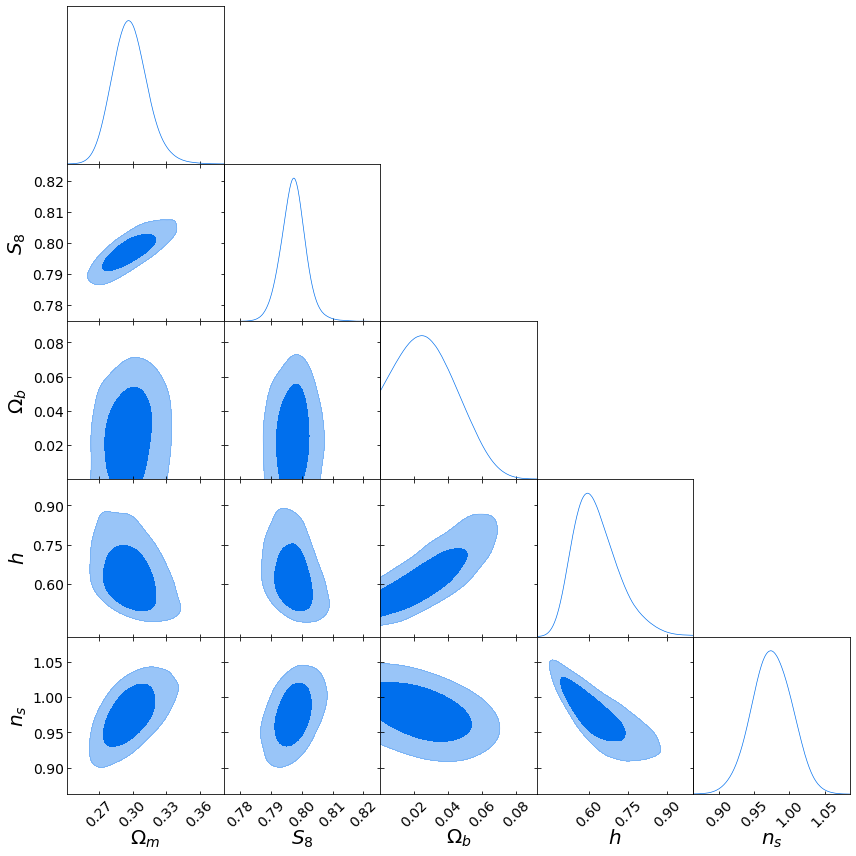

Population 15/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 7200 samples, validate on 800 samples
Epoch 1/100
7200/7200 [==============================] - 20s 3ms/step - loss: 3.8168 - val_loss: 3.8583
Epoch 2/100
7200/7200 [==============================] - 24s 3ms/step - loss: 3.8150 - val_loss: 3.8875
Epoch 3/100
7200/7200 [==============================] - 20s 3ms/step - loss: 3.8187 - val_loss: 3.8911
Epoch 4/100
7200/7200 [==============================] - 16s 2ms/step - loss: 3.8475 - val_loss: 3.9280
Epoch 5/100
7200/7200 [==============================] - 19s 3ms/step - loss: 3.8392 - val_loss: 3.8646
Epoch 6/100
7200/7200 [==============================] - 23s 3ms/step - loss: 3.8366 - val_loss: 3.8347
Epoch 7/100
7200/7200 [==============================] - 16s 2ms/step - loss: 3.8094 - val_loss: 3.9320
Epoch 8/100
7200/7200 [==============================] - 14s 2ms/step - loss: 3.8173 - val_loss: 3.8281
Epoch 9/100
7200/7200 [====================

Epoch 37/100
7200/7200 [==============================] - 30s 4ms/step - loss: 3.7294 - val_loss: 3.7880
Epoch 38/100
7200/7200 [==============================] - 30s 4ms/step - loss: 3.7299 - val_loss: 3.7878
Epoch 39/100
7200/7200 [==============================] - 30s 4ms/step - loss: 3.7295 - val_loss: 3.7879
Epoch 40/100
7200/7200 [==============================] - 32s 5ms/step - loss: 3.7295 - val_loss: 3.7876
Epoch 41/100
7200/7200 [==============================] - 30s 4ms/step - loss: 3.7293 - val_loss: 3.7858
Epoch 42/100
7200/7200 [==============================] - 30s 4ms/step - loss: 3.7284 - val_loss: 3.7842
Epoch 43/100
7200/7200 [==============================] - 30s 4ms/step - loss: 3.7283 - val_loss: 3.7837
Epoch 44/100
7200/7200 [==============================] - 38s 5ms/step - loss: 3.7286 - val_loss: 3.7838
Epoch 45/100
7200/7200 [==============================] - 30s 4ms/step - loss: 3.7285 - val_loss: 3.7845
Epoch 46/100
7200/7200 [==============================]

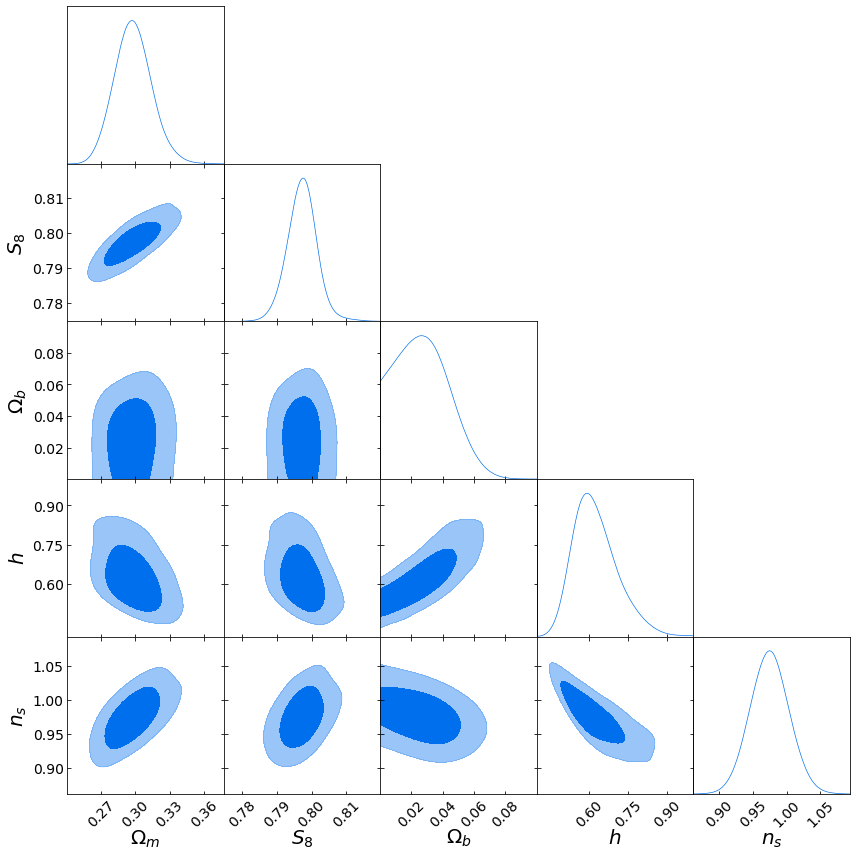

Population 16/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 7650 samples, validate on 850 samples
Epoch 1/100
7650/7650 [==============================] - 14s 2ms/step - loss: 3.8263 - val_loss: 3.7660
Epoch 2/100
7650/7650 [==============================] - 14s 2ms/step - loss: 3.8249 - val_loss: 3.7811
Epoch 3/100
7650/7650 [==============================] - 13s 2ms/step - loss: 3.8171 - val_loss: 3.7390
Epoch 4/100
7650/7650 [==============================] - 14s 2ms/step - loss: 3.8095 - val_loss: 3.7143
Epoch 5/100
7650/7650 [==============================] - 14s 2ms/step - loss: 3.8367 - val_loss: 3.8553
Epoch 6/100
7650/7650 [==============================] - 13s 2ms/step - loss: 3.8155 - val_loss: 3.6725
Epoch 7/100
7650/7650 [==============================] - 14s 2ms/step - loss: 3.7923 - val_loss: 3.6909
Epoch 8/100
7650/7650 [==============================] - 13s 2ms/step - loss: 3.8375 - val_loss: 3.7620
Epoch 9/100
7650/7650 [====================

Epoch 52/100
7650/7650 [==============================] - 33s 4ms/step - loss: 3.7266 - val_loss: 3.6620
Epoch 53/100
7650/7650 [==============================] - 33s 4ms/step - loss: 3.7269 - val_loss: 3.6607
Epoch 54/100
7650/7650 [==============================] - 34s 4ms/step - loss: 3.7267 - val_loss: 3.6578
Epoch 55/100
7650/7650 [==============================] - 33s 4ms/step - loss: 3.7265 - val_loss: 3.6560
Epoch 56/100
7650/7650 [==============================] - 33s 4ms/step - loss: 3.7267 - val_loss: 3.6558
Epoch 57/100
7650/7650 [==============================] - 33s 4ms/step - loss: 3.7266 - val_loss: 3.6570
Epoch 58/100
7650/7650 [==============================] - 33s 4ms/step - loss: 3.7263 - val_loss: 3.6588
Epoch 59/100
7650/7650 [==============================] - 43s 6ms/step - loss: 3.7264 - val_loss: 3.6594
Epoch 60/100
7650/7650 [==============================] - 34s 4ms/step - loss: 3.7264 - val_loss: 3.6583
Epoch 61/100
7650/7650 [==============================]

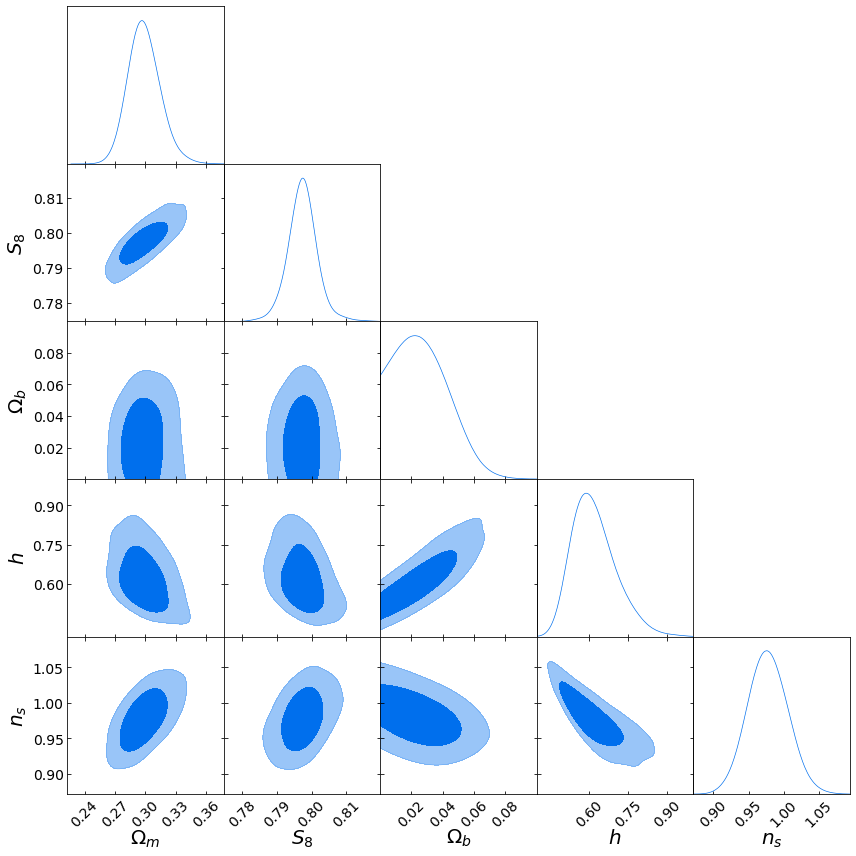

Population 17/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 8100 samples, validate on 900 samples
Epoch 1/100
8100/8100 [==============================] - 15s 2ms/step - loss: 3.8053 - val_loss: 3.6597
Epoch 2/100
8100/8100 [==============================] - 15s 2ms/step - loss: 3.8137 - val_loss: 3.6479
Epoch 3/100
8100/8100 [==============================] - 15s 2ms/step - loss: 3.8171 - val_loss: 3.6254
Epoch 4/100
8100/8100 [==============================] - 15s 2ms/step - loss: 3.8025 - val_loss: 3.6489
Epoch 5/100
8100/8100 [==============================] - 16s 2ms/step - loss: 3.8196 - val_loss: 3.7142
Epoch 6/100
8100/8100 [==============================] - 24s 3ms/step - loss: 3.8153 - val_loss: 3.7143
Epoch 7/100
8100/8100 [==============================] - 15s 2ms/step - loss: 3.8447 - val_loss: 3.6996
Epoch 8/100
8100/8100 [==============================] - 15s 2ms/step - loss: 3.8206 - val_loss: 3.6306
Epoch 9/100
8100/8100 [====================

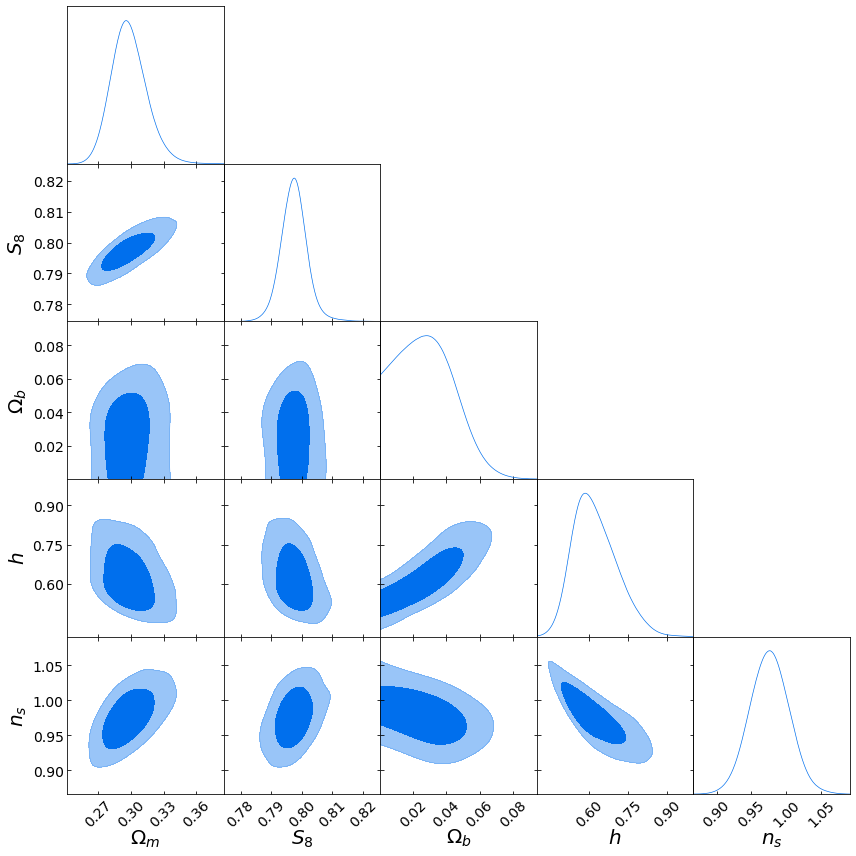

Population 18/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.2701909  0.79210846 0.0447729  0.77600787 0.94543417] (rank 0)
Simulator returns exception for parameter values: [0.2701909  0.79210846 0.0447729  0.77600787 0.94543417] (rank 0)
Simulator returns exception for parameter values: [0.2701909  0.79210846 0.0447729  0.77600787 0.94543417] (rank 0)
Done.
Train on 8550 samples, validate on 950 samples
Epoch 1/100
8550/8550 [==============================] - 15s 2ms/step - loss: 3.7892 - val_loss: 3.7429
Epoch 2/100
8550/8550 [==============================] - 16s 2ms/step - loss: 3.8147 - val_loss: 3.9913
Epoch 3/100
8550/8550 [==============================] - 15s 2ms/step - loss: 3.8379 - val_loss: 3.7791
Epoch 4/100
8550/8550 [==============================] - 15s 2ms/step - loss: 3.7859 - val_loss: 3.8249
Epoch 5/100
8550/8550 [==============================] - 15s 2ms/step - loss: 3.8252 - val_loss: 3.7580
Epoch 6

Epoch 27/100
8550/8550 [==============================] - 39s 5ms/step - loss: 3.7186 - val_loss: 3.6928
Epoch 28/100
8550/8550 [==============================] - 40s 5ms/step - loss: 3.7198 - val_loss: 3.6915
Epoch 29/100
8550/8550 [==============================] - 39s 5ms/step - loss: 3.7192 - val_loss: 3.6907
Epoch 30/100
8550/8550 [==============================] - 40s 5ms/step - loss: 3.7175 - val_loss: 3.6922
Epoch 31/100
8550/8550 [==============================] - 40s 5ms/step - loss: 3.7176 - val_loss: 3.6931
Epoch 32/100
8550/8550 [==============================] - 39s 5ms/step - loss: 3.7172 - val_loss: 3.6924
Epoch 33/100
8550/8550 [==============================] - 40s 5ms/step - loss: 3.7157 - val_loss: 3.6929
Epoch 34/100
8550/8550 [==============================] - 39s 5ms/step - loss: 3.7155 - val_loss: 3.6940
Epoch 35/100
8550/8550 [==============================] - 39s 5ms/step - loss: 3.7158 - val_loss: 3.6944
Epoch 36/100
8550/8550 [==============================]

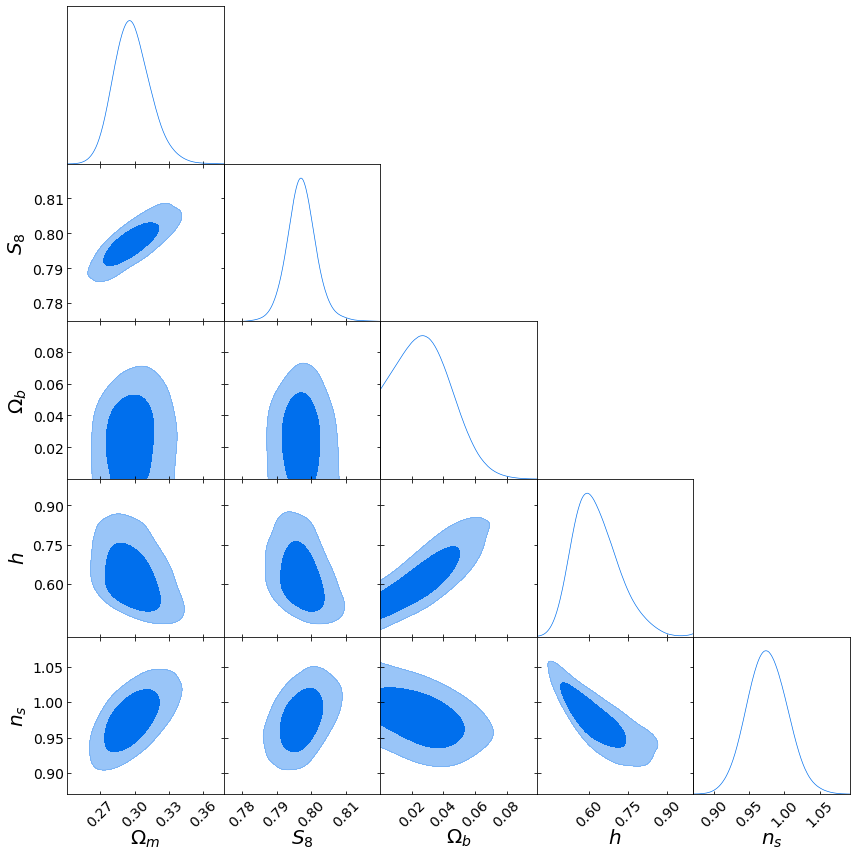

Population 19/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 17s 2ms/step - loss: 3.7712 - val_loss: 3.8993
Epoch 2/100
9000/9000 [==============================] - 19s 2ms/step - loss: 3.7934 - val_loss: 4.0247
Epoch 3/100
9000/9000 [==============================] - 24s 3ms/step - loss: 3.8026 - val_loss: 3.9301
Epoch 4/100
9000/9000 [==============================] - 18s 2ms/step - loss: 3.7863 - val_loss: 3.8779
Epoch 5/100
9000/9000 [==============================] - 16s 2ms/step - loss: 3.7962 - val_loss: 3.8965
Epoch 6/100
9000/9000 [==============================] - 17s 2ms/step - loss: 3.7952 - val_loss: 3.9045
Epoch 7/100
9000/9000 [==============================] - 16s 2ms/step - loss: 3.7871 - val_loss: 3.9156
Epoch 8/100
9000/9000 [==============================] - 16s 2ms/step - loss: 3.7829 - val_loss: 3.9069
Epoch 9/100
9000/9000 [===================

Epoch 28/100
9000/9000 [==============================] - 47s 5ms/step - loss: 3.7044 - val_loss: 3.8379
Epoch 29/100
9000/9000 [==============================] - 45s 5ms/step - loss: 3.7040 - val_loss: 3.8387
Epoch 30/100
9000/9000 [==============================] - 46s 5ms/step - loss: 3.7054 - val_loss: 3.8387
Epoch 31/100
9000/9000 [==============================] - 46s 5ms/step - loss: 3.7055 - val_loss: 3.8380
Epoch 32/100
9000/9000 [==============================] - 70s 8ms/step - loss: 3.7046 - val_loss: 3.8377
Epoch 33/100
9000/9000 [==============================] - 46s 5ms/step - loss: 3.7044 - val_loss: 3.8364
Epoch 34/100
9000/9000 [==============================] - 44s 5ms/step - loss: 3.7038 - val_loss: 3.8342
Epoch 35/100
9000/9000 [==============================] - 44s 5ms/step - loss: 3.7026 - val_loss: 3.8333
Epoch 36/100
9000/9000 [==============================] - 46s 5ms/step - loss: 3.7024 - val_loss: 3.8335
Epoch 37/100
9000/9000 [==============================]

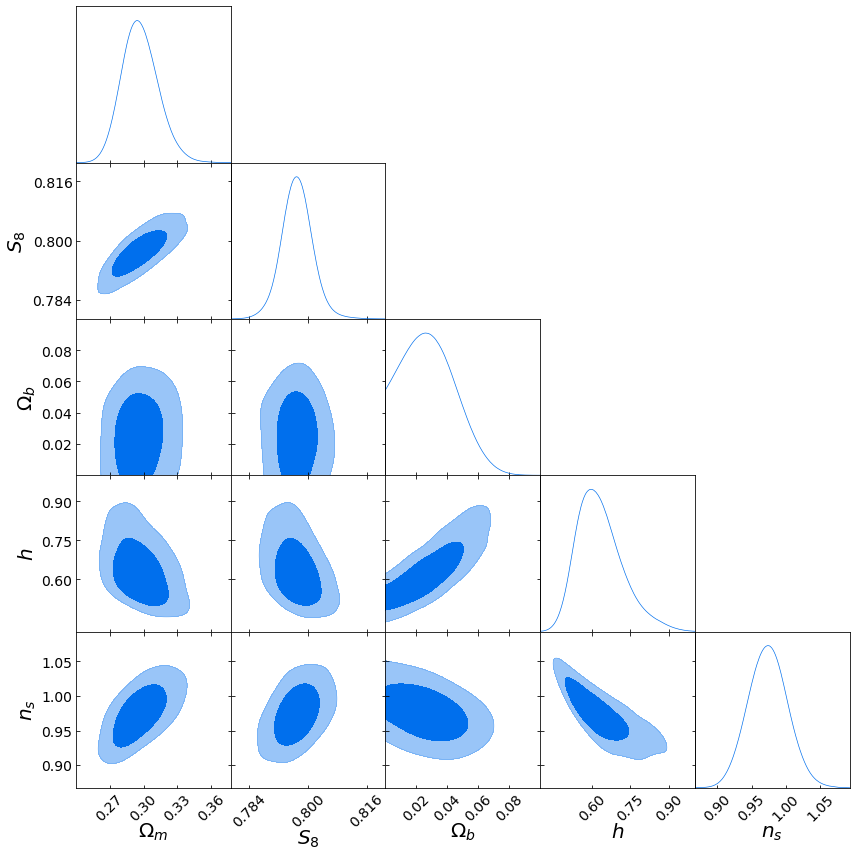

Population 20/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 9450 samples, validate on 1050 samples
Epoch 1/100
9450/9450 [==============================] - 16s 2ms/step - loss: 3.8063 - val_loss: 3.9711
Epoch 2/100
9450/9450 [==============================] - 16s 2ms/step - loss: 3.8065 - val_loss: 3.9578
Epoch 3/100
9450/9450 [==============================] - 17s 2ms/step - loss: 3.8078 - val_loss: 3.9550
Epoch 4/100
9450/9450 [==============================] - 16s 2ms/step - loss: 3.8050 - val_loss: 4.0614
Epoch 5/100
9450/9450 [==============================] - 16s 2ms/step - loss: 3.7837 - val_loss: 3.9118
Epoch 6/100
9450/9450 [==============================] - 16s 2ms/step - loss: 3.7927 - val_loss: 3.9184
Epoch 7/100
9450/9450 [==============================] - 16s 2ms/step - loss: 3.8055 - val_loss: 3.9655
Epoch 8/100
9450/9450 [==============================] - 16s 2ms/step - loss: 3.8059 - val_loss: 3.9002
Epoch 9/100
9450/9450 [===================

Epoch 41/100
9450/9450 [==============================] - 46s 5ms/step - loss: 3.7044 - val_loss: 3.8731
Epoch 42/100
9450/9450 [==============================] - 45s 5ms/step - loss: 3.7053 - val_loss: 3.8736
Epoch 43/100
9450/9450 [==============================] - 47s 5ms/step - loss: 3.7062 - val_loss: 3.8736
Epoch 44/100
9450/9450 [==============================] - 45s 5ms/step - loss: 3.7044 - val_loss: 3.8755
Epoch 45/100
9450/9450 [==============================] - 45s 5ms/step - loss: 3.7040 - val_loss: 3.8780
Epoch 46/100
9450/9450 [==============================] - 45s 5ms/step - loss: 3.7052 - val_loss: 3.8772
Epoch 47/100
9450/9450 [==============================] - 46s 5ms/step - loss: 3.7046 - val_loss: 3.8750
Epoch 48/100
9450/9450 [==============================] - 46s 5ms/step - loss: 3.7036 - val_loss: 3.8745
Epoch 49/100
9450/9450 [==============================] - 45s 5ms/step - loss: 3.7043 - val_loss: 3.8745
Epoch 50/100
9450/9450 [==============================]

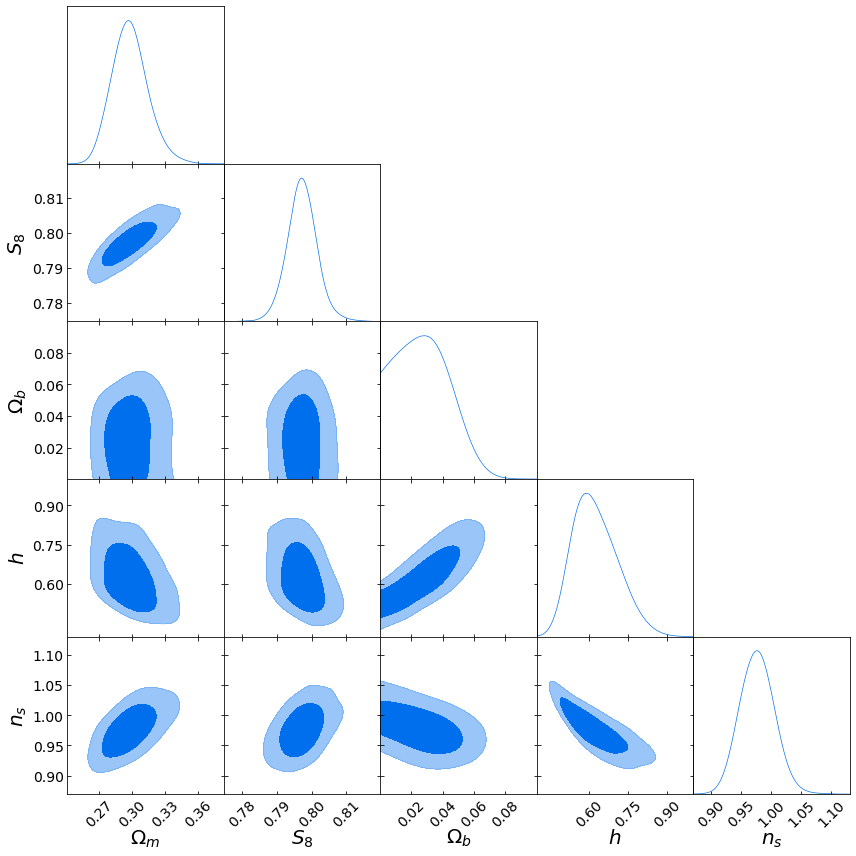

Population 21/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 9900 samples, validate on 1100 samples
Epoch 1/100
9900/9900 [==============================] - 17s 2ms/step - loss: 3.7764 - val_loss: 3.9193
Epoch 2/100
9900/9900 [==============================] - 20s 2ms/step - loss: 3.7993 - val_loss: 3.9082
Epoch 3/100
9900/9900 [==============================] - 20s 2ms/step - loss: 3.7907 - val_loss: 3.9283
Epoch 4/100
9900/9900 [==============================] - 19s 2ms/step - loss: 3.7860 - val_loss: 3.9697
Epoch 5/100
9900/9900 [==============================] - 19s 2ms/step - loss: 3.8169 - val_loss: 3.9057
Epoch 6/100
9900/9900 [==============================] - 19s 2ms/step - loss: 3.8022 - val_loss: 3.8851
Epoch 7/100
9900/9900 [==============================] - 20s 2ms/step - loss: 3.7977 - val_loss: 3.9625
Epoch 8/100
9900/9900 [==============================] - 19s 2ms/step - loss: 3.8093 - val_loss: 3.9300
Epoch 9/100
9900/9900 [===================

Epoch 52/100
9900/9900 [==============================] - 48s 5ms/step - loss: 3.7072 - val_loss: 3.8592
Epoch 53/100
9900/9900 [==============================] - 49s 5ms/step - loss: 3.7073 - val_loss: 3.8590
Epoch 54/100
9900/9900 [==============================] - 48s 5ms/step - loss: 3.7070 - val_loss: 3.8595
Epoch 55/100
9900/9900 [==============================] - 49s 5ms/step - loss: 3.7070 - val_loss: 3.8600
Epoch 56/100
9900/9900 [==============================] - 48s 5ms/step - loss: 3.7071 - val_loss: 3.8598
Sampling approximate posterior...
Done.
Saving seq_train_post_21.pdf


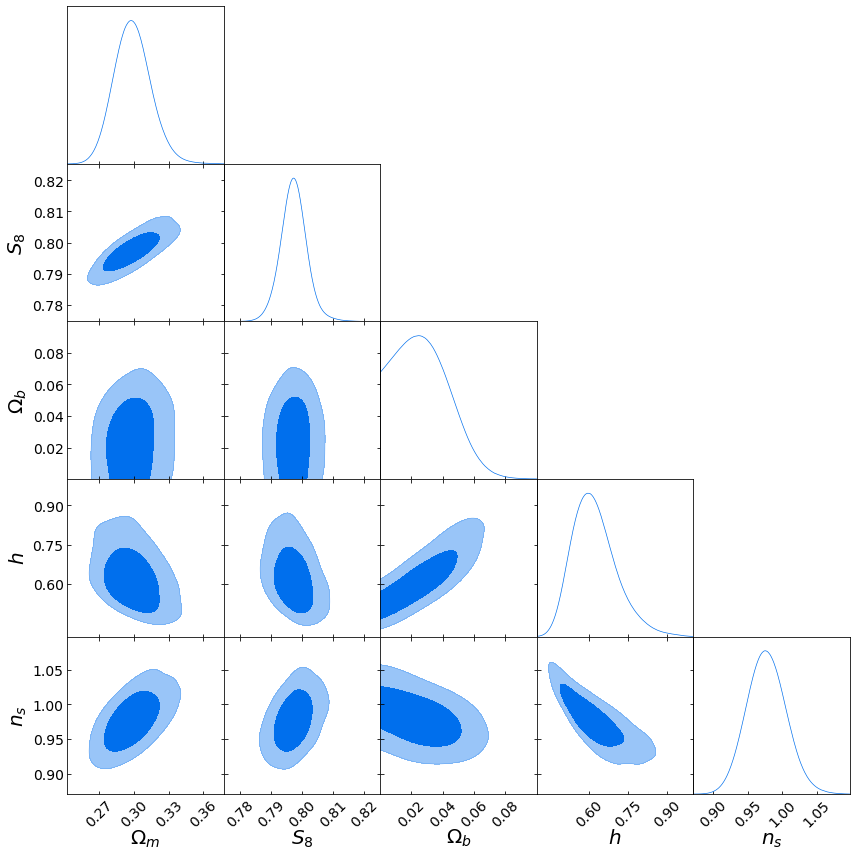

Population 22/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 10350 samples, validate on 1150 samples
Epoch 1/100
10350/10350 [==============================] - 18s 2ms/step - loss: 3.7833 - val_loss: 3.9103
Epoch 2/100
10350/10350 [==============================] - 18s 2ms/step - loss: 3.8007 - val_loss: 3.9533
Epoch 3/100
10350/10350 [==============================] - 18s 2ms/step - loss: 3.7930 - val_loss: 3.9188
Epoch 4/100
10350/10350 [==============================] - 18s 2ms/step - loss: 3.7775 - val_loss: 4.0013
Epoch 5/100
10350/10350 [==============================] - 18s 2ms/step - loss: 3.7968 - val_loss: 3.9299
Epoch 6/100
10350/10350 [==============================] - 18s 2ms/step - loss: 3.7849 - val_loss: 3.9799
Epoch 7/100
10350/10350 [==============================] - 18s 2ms/step - loss: 3.8170 - val_loss: 3.9143
Epoch 8/100
10350/10350 [==============================] - 18s 2ms/step - loss: 3.8042 - val_loss: 3.8958
Epoch 9/100
10350/10350 [

10350/10350 [==============================] - 38s 4ms/step - loss: 3.7123 - val_loss: 3.8788
Epoch 49/100
10350/10350 [==============================] - 38s 4ms/step - loss: 3.7122 - val_loss: 3.8796
Epoch 50/100
10350/10350 [==============================] - 38s 4ms/step - loss: 3.7120 - val_loss: 3.8807
Epoch 51/100
10350/10350 [==============================] - 38s 4ms/step - loss: 3.7120 - val_loss: 3.8812
Epoch 52/100
10350/10350 [==============================] - 38s 4ms/step - loss: 3.7119 - val_loss: 3.8806
Epoch 53/100
10350/10350 [==============================] - 38s 4ms/step - loss: 3.7117 - val_loss: 3.8797
Epoch 54/100
10350/10350 [==============================] - 38s 4ms/step - loss: 3.7116 - val_loss: 3.8794
Epoch 55/100
10350/10350 [==============================] - 38s 4ms/step - loss: 3.7116 - val_loss: 3.8798
Epoch 56/100
10350/10350 [==============================] - 39s 4ms/step - loss: 3.7116 - val_loss: 3.8807
Epoch 57/100
10350/10350 [========================

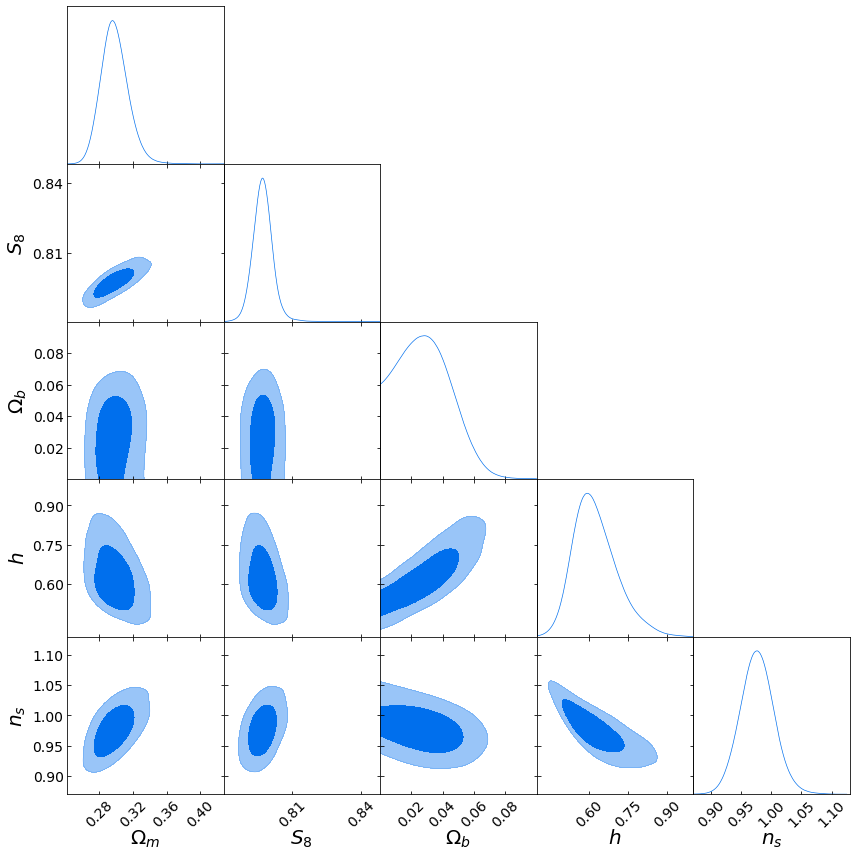

Population 23/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 10800 samples, validate on 1200 samples
Epoch 1/100
10800/10800 [==============================] - 16s 1ms/step - loss: 3.7882 - val_loss: 3.9568
Epoch 2/100
10800/10800 [==============================] - 16s 1ms/step - loss: 3.8031 - val_loss: 3.9459
Epoch 3/100
10800/10800 [==============================] - 16s 1ms/step - loss: 3.7993 - val_loss: 3.9171
Epoch 4/100
10800/10800 [==============================] - 16s 1ms/step - loss: 3.8142 - val_loss: 3.9746
Epoch 5/100
10800/10800 [==============================] - 16s 1ms/step - loss: 3.7982 - val_loss: 3.9121
Epoch 6/100
10800/10800 [==============================] - 16s 1ms/step - loss: 3.7934 - val_loss: 3.9490
Epoch 7/100
10800/10800 [==============================] - 17s 2ms/step - loss: 3.8192 - val_loss: 3.9489
Epoch 8/100
10800/10800 [==============================] - 16s 1ms/step - loss: 3.8049 - val_loss: 3.9304
Epoch 9/100
10800/10800 [

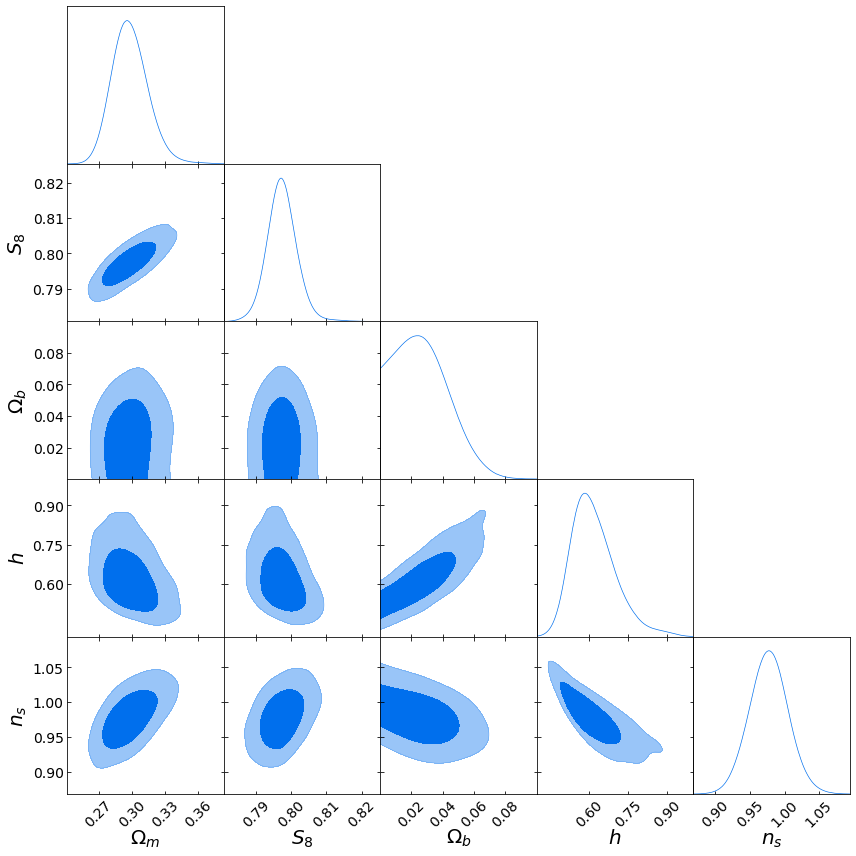

Final round of training with larger SGD batch size...
Train on 10800 samples, validate on 1200 samples
Epoch 1/300
10800/10800 [==============================] - 45s 4ms/step - loss: 3.7171 - val_loss: 3.8809
Epoch 2/300
10800/10800 [==============================] - 44s 4ms/step - loss: 3.7162 - val_loss: 3.8822
Epoch 3/300
10800/10800 [==============================] - 44s 4ms/step - loss: 3.7171 - val_loss: 3.8824
Epoch 4/300
10800/10800 [==============================] - 45s 4ms/step - loss: 3.7171 - val_loss: 3.8814
Epoch 5/300
10800/10800 [==============================] - 45s 4ms/step - loss: 3.7162 - val_loss: 3.8811
Epoch 6/300
10800/10800 [==============================] - 44s 4ms/step - loss: 3.7162 - val_loss: 3.8808
Epoch 7/300
10800/10800 [==============================] - 45s 4ms/step - loss: 3.7164 - val_loss: 3.8796
Epoch 8/300
10800/10800 [==============================] - 44s 4ms/step - loss: 3.7158 - val_loss: 3.8787
Epoch 9/300
10800/10800 [========================

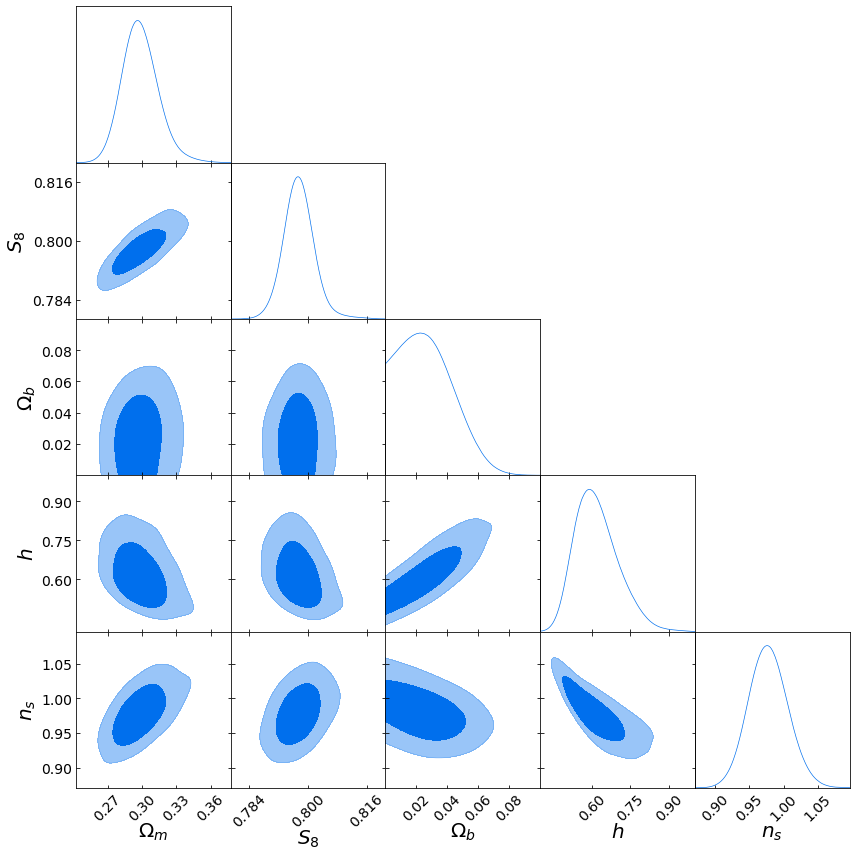

In [9]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
mdn.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, proposal, simulator_args=simulator_args, compressor_args=compressor_args)

In [10]:
n_sims = mdn.n_sim_trace[1:]
loss_trace = mdn.loss_trace[1:]

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


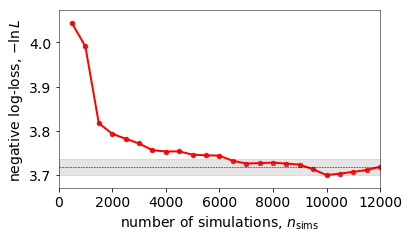

In [13]:
plt.close()
columnwidth = 15 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black',
                 'axes.color_cycle': ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00']})

# Trace plot of the loss as a function of the number of simulations
plt.scatter(n_sims, loss_trace, s = 20)
plt.plot(n_sims, loss_trace, color = 'red', lw = 2)
plt.fill_between(mdn.n_sim_trace, loss_trace[-1]*0.995*np.ones(len(mdn.n_sim_trace)), loss_trace[-1]*1.005*np.ones(len(mdn.n_sim_trace)), color = 'grey', alpha = 0.2 )
plt.xlim(0, mdn.n_sim_trace[-1])
plt.axhline(loss_trace[-1], color = 'black', ls = '--')
plt.xlabel(r'number of simulations, $n_\mathrm{sims}$')
plt.ylabel(r'negative log-loss, $-\mathrm{ln}\,L$')
plt.tight_layout()
#plt.show()
#plt.savefig('../paper_II/plots/convergence_marginal.pdf')

In [18]:
# Generate draws from asymptotic posterior
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])

In [19]:
samples = [mdn.posterior_samples, samples_asymptotic]
mc_samples = [MCSamples(samples=s, names = mdn.names, labels = mdn.labels, ranges = mdn.ranges) for s in samples]

In [14]:
# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black',
                 'axes.color_cycle': ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00']})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False], normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1], contour_ls = ['-','-.'], contour_colors=['#E41A1C','#377EB8'])

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.sho
#plt.savefig('../paper_II/plots/contours.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


NameError: name 'mc_samples' is not defined

In [36]:
f = open('simulators/cosmic_shear_pre-ran_sims/Finv.dat', 'w')
np.savetxt(f, Finv)
f.close()